In [1]:
import dill
with open("lcbench_known_cost_metrics_per_acq.pkl", "rb") as f:
    metrics_per_acq = dill.load(f)

In [2]:
dataset_names = ['Fashion-MNIST', 'adult', 'higgs', 'volkert']
acquisition_functions = {
        "LogEIC": "LogEIC",
        "StablePBGI(1e-3)": "PBGI(1e-3)",
        "StablePBGI(1e-4)": "PBGI(1e-4)", 
        "StablePBGI(1e-5)": "PBGI(1e-5)", 
        "LCB": "LCB",
        "TS": "TS"
    }

In [3]:
import matplotlib.pyplot as plt

plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'Times New Roman'

In [4]:
best_acc_per_dataset = {
    'Fashion-MNIST': 90.17316017316017,
    'adult': 83.00552211950115,
    'higgs': 71.86302385956238,
    'volkert': 62.765681026866915
}

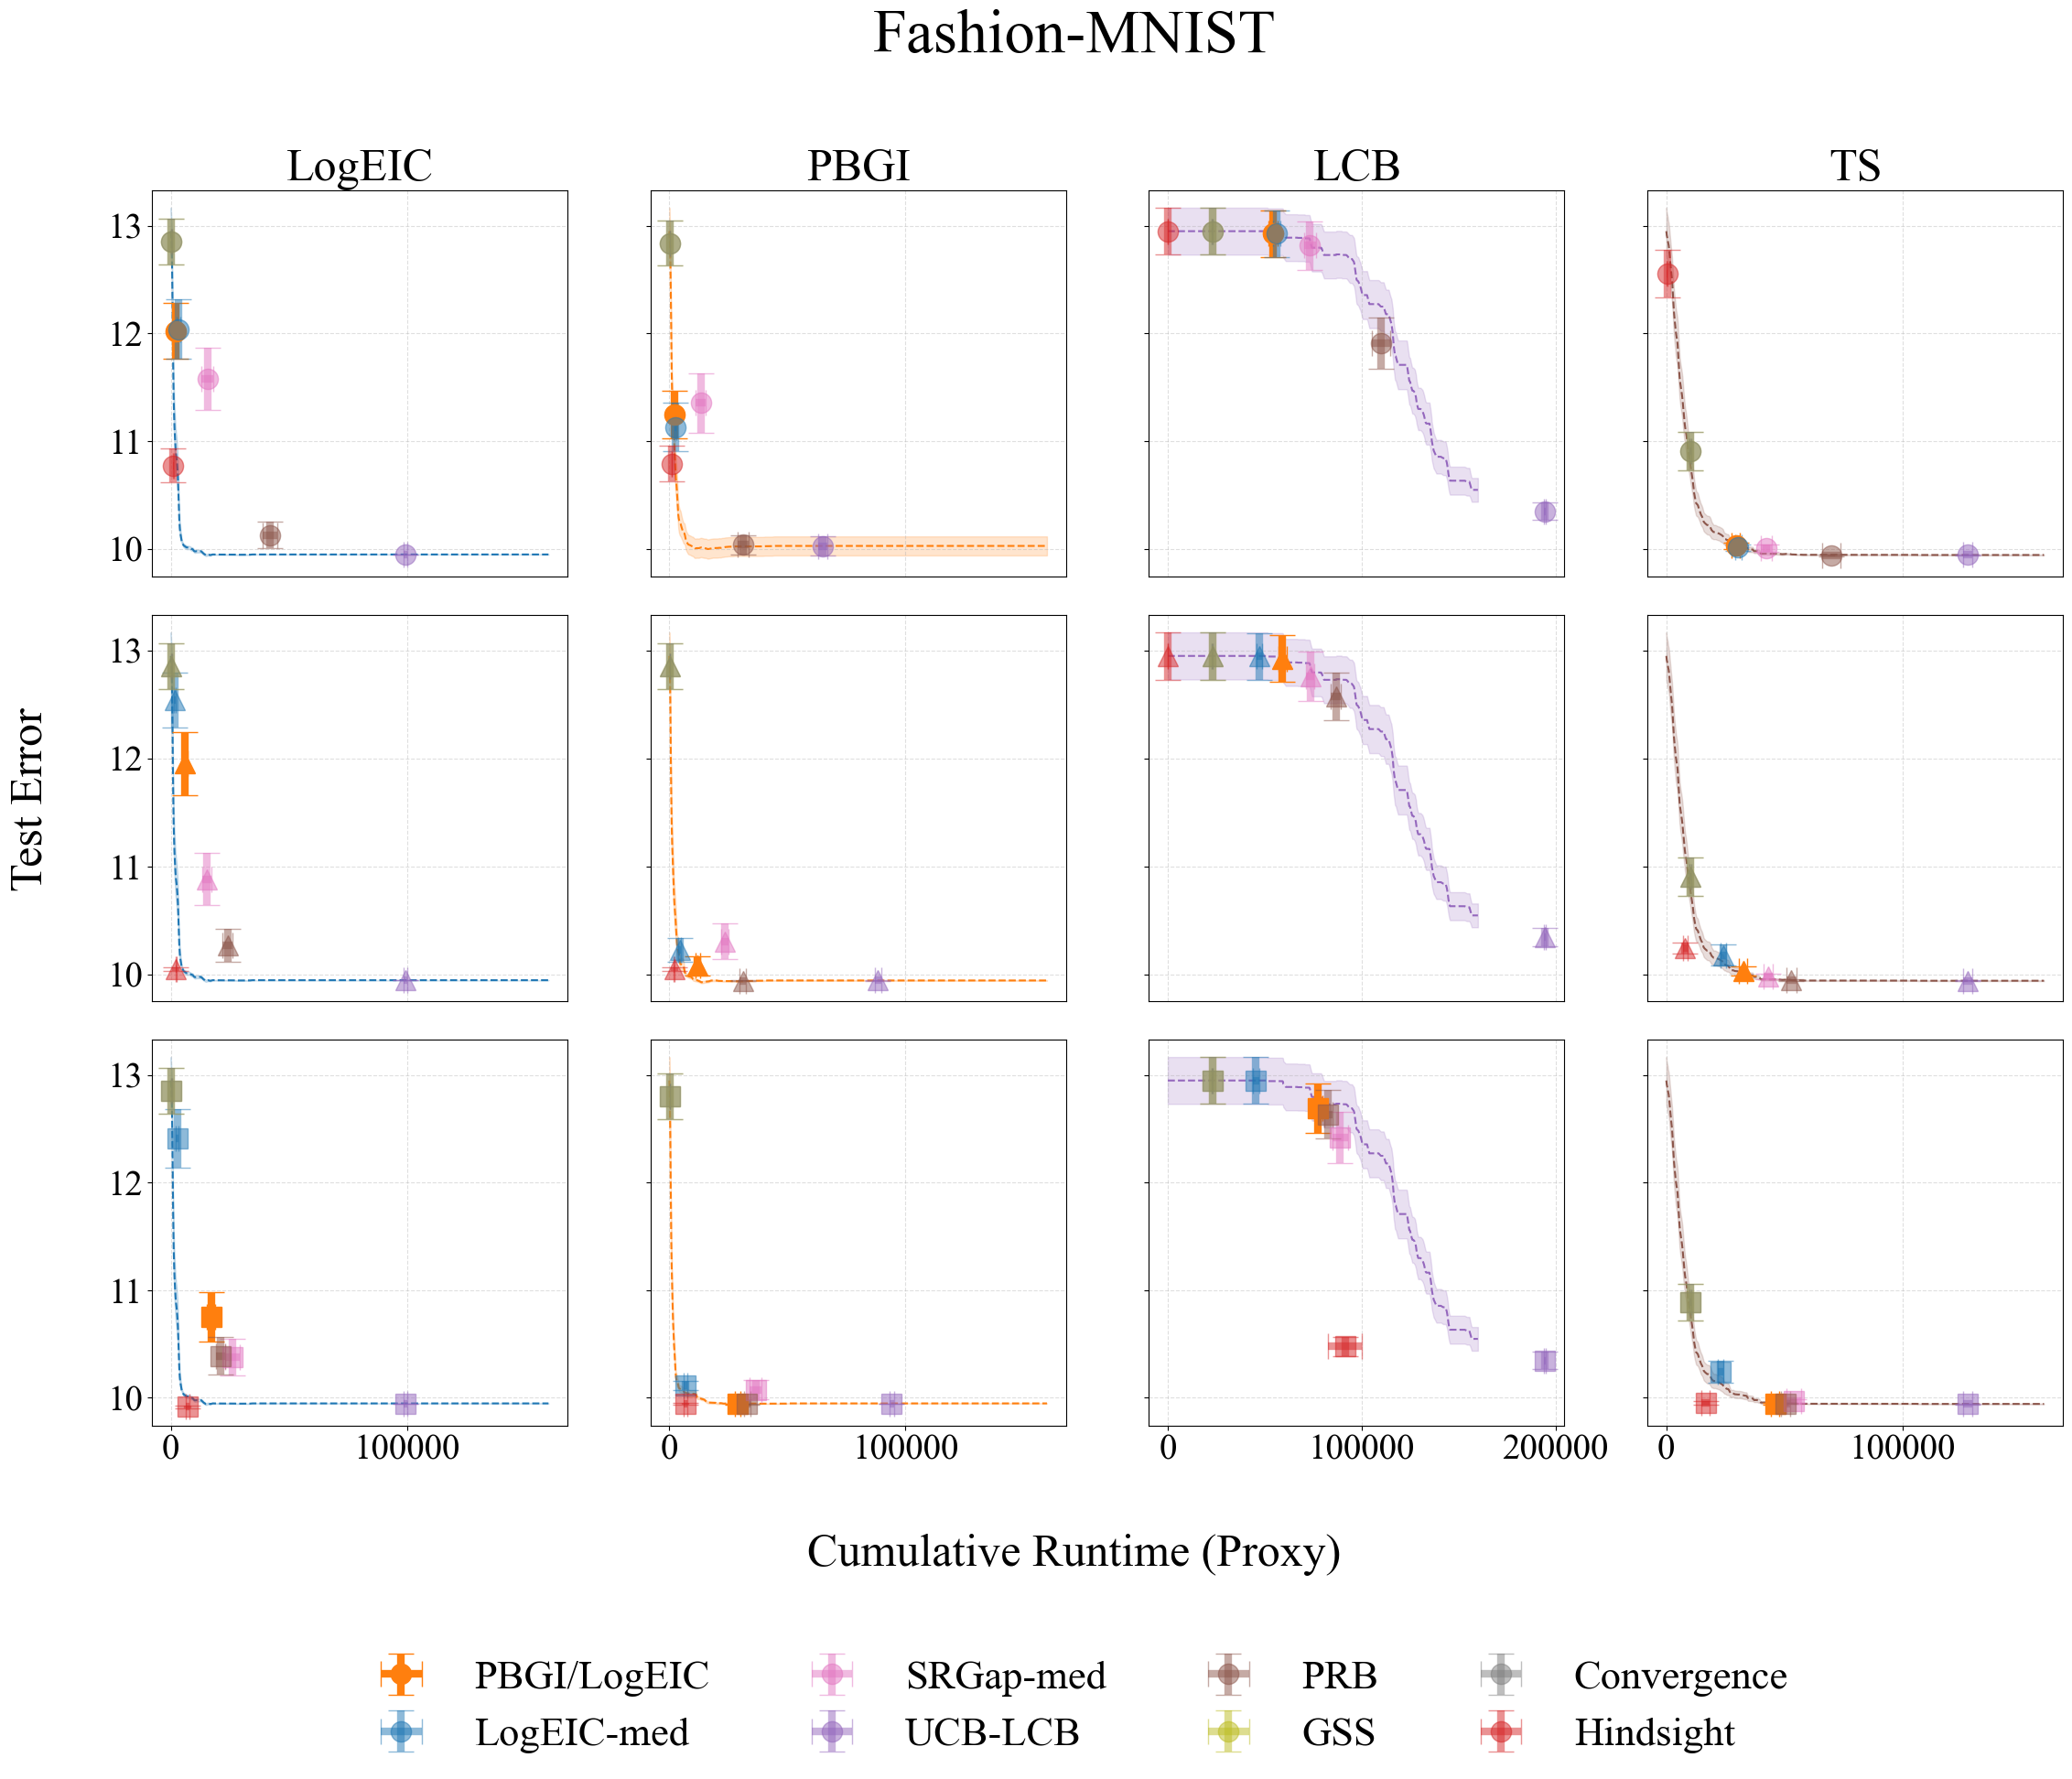

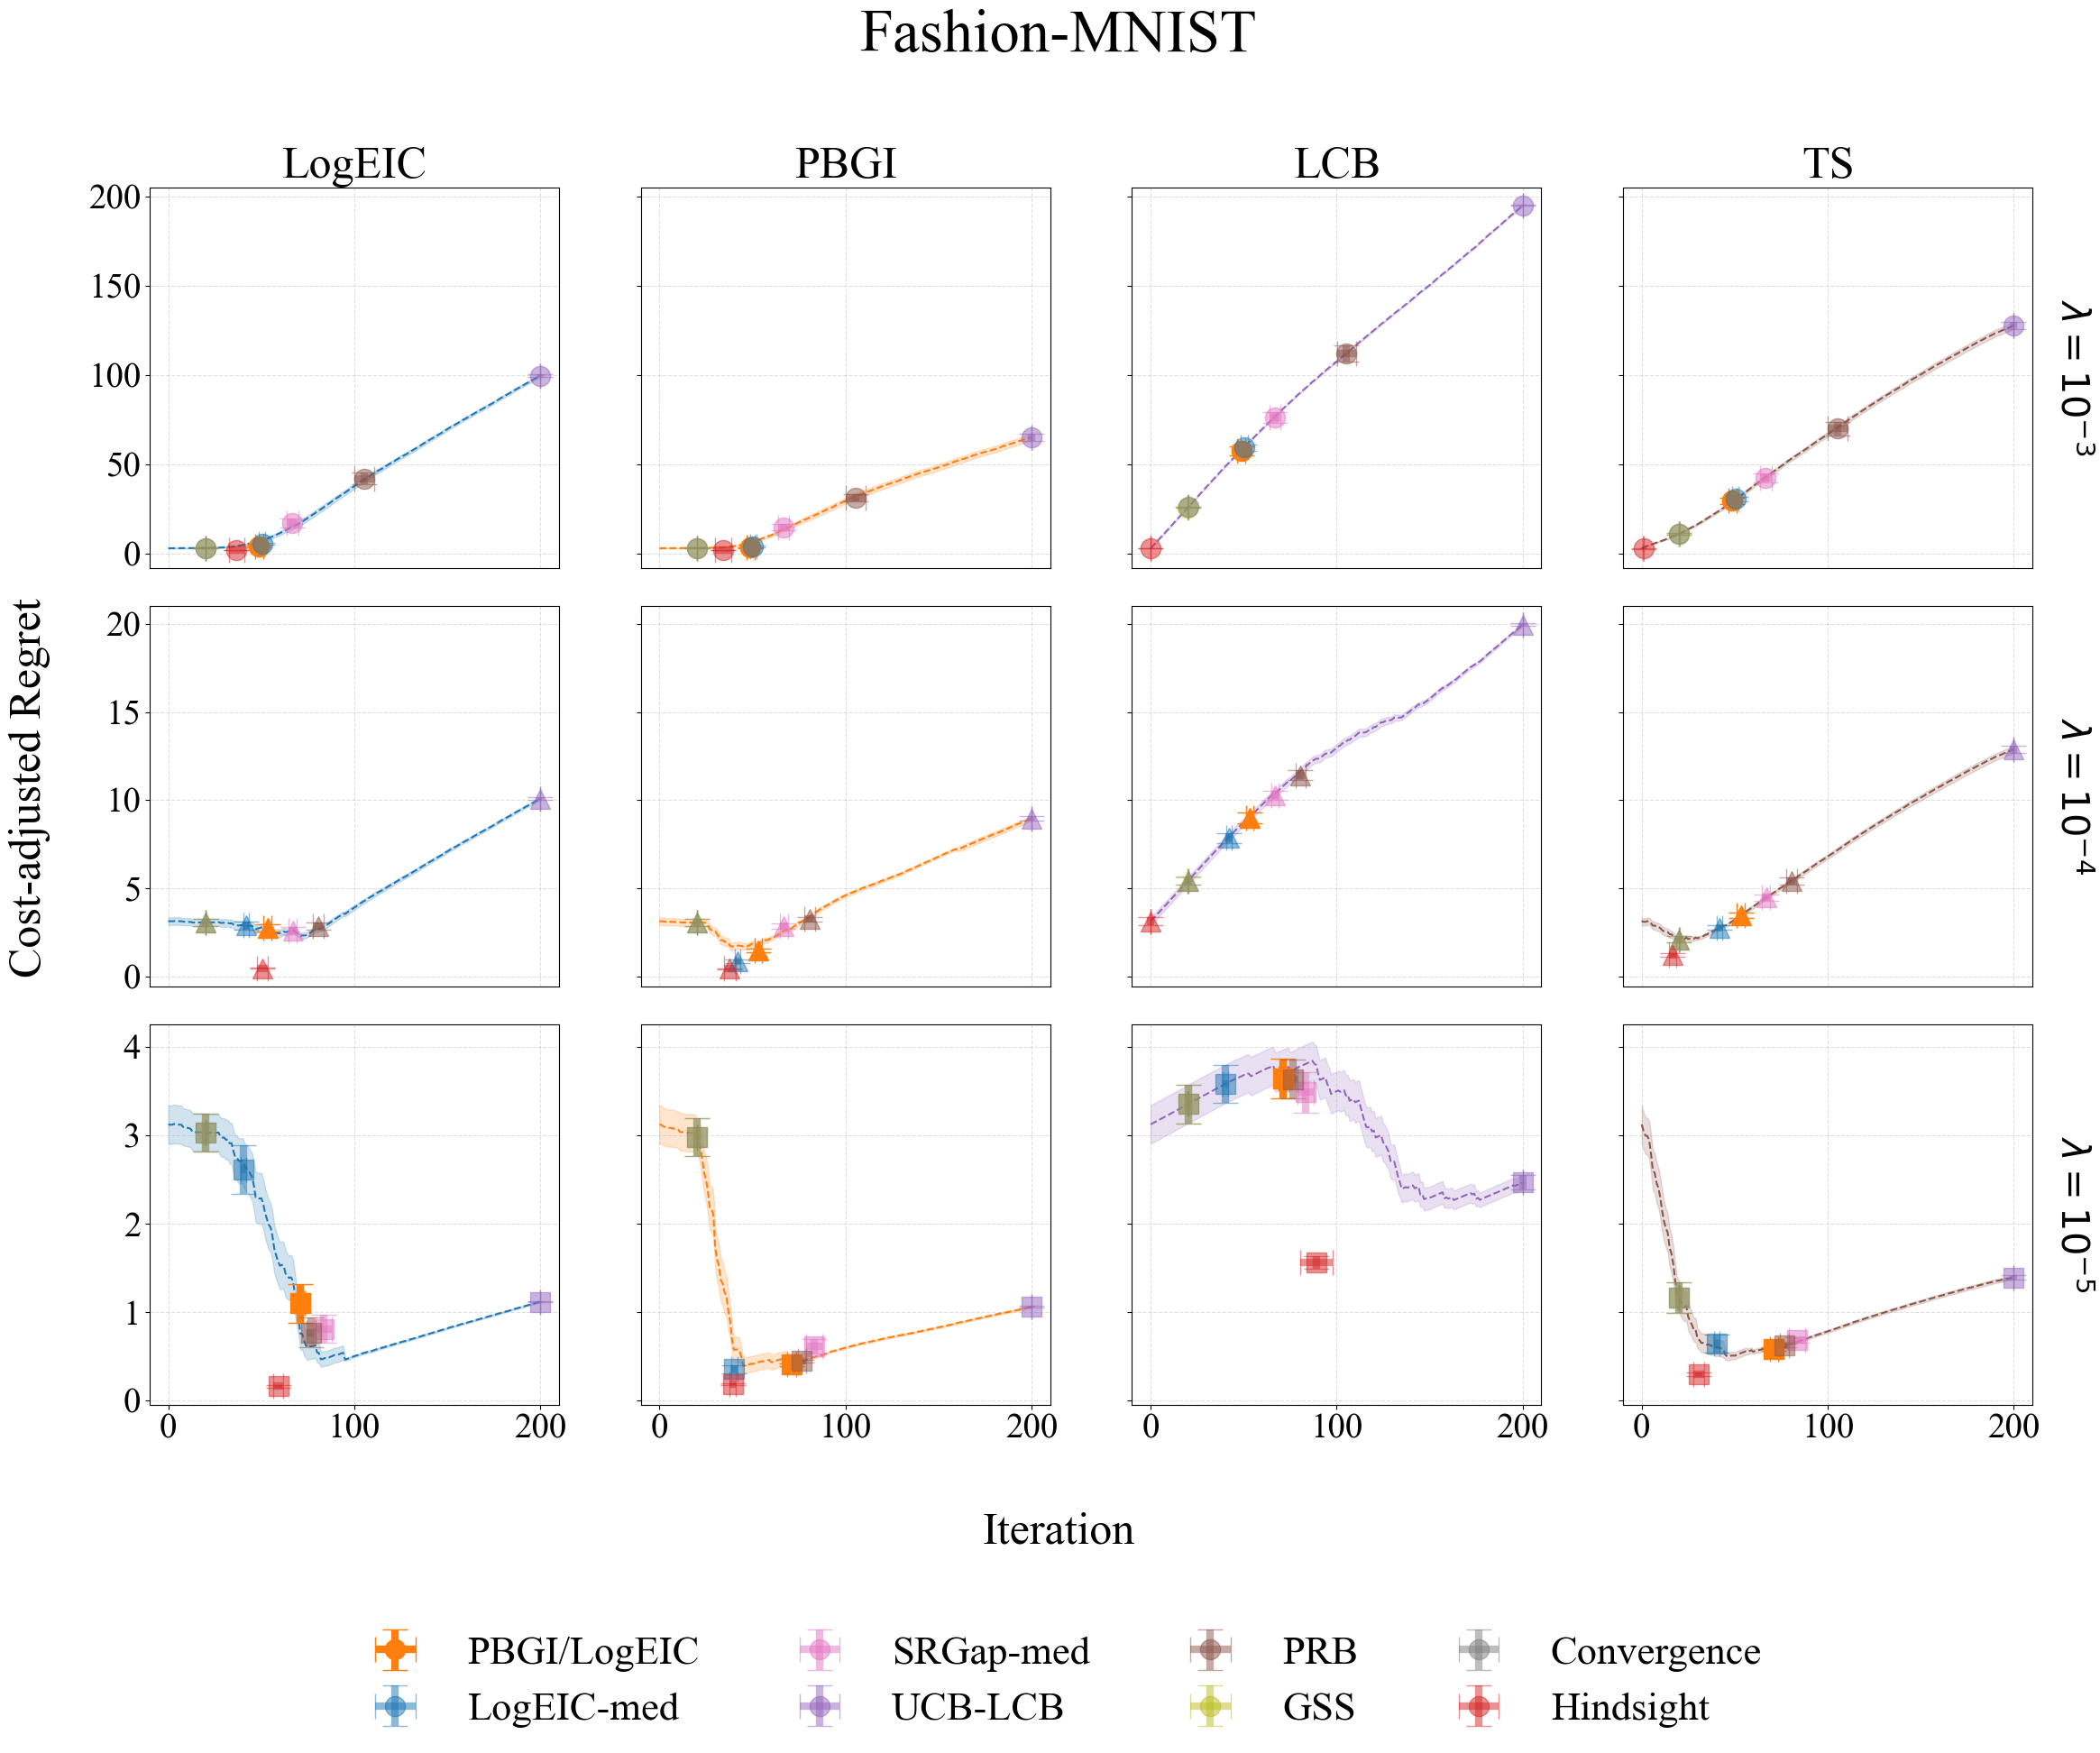

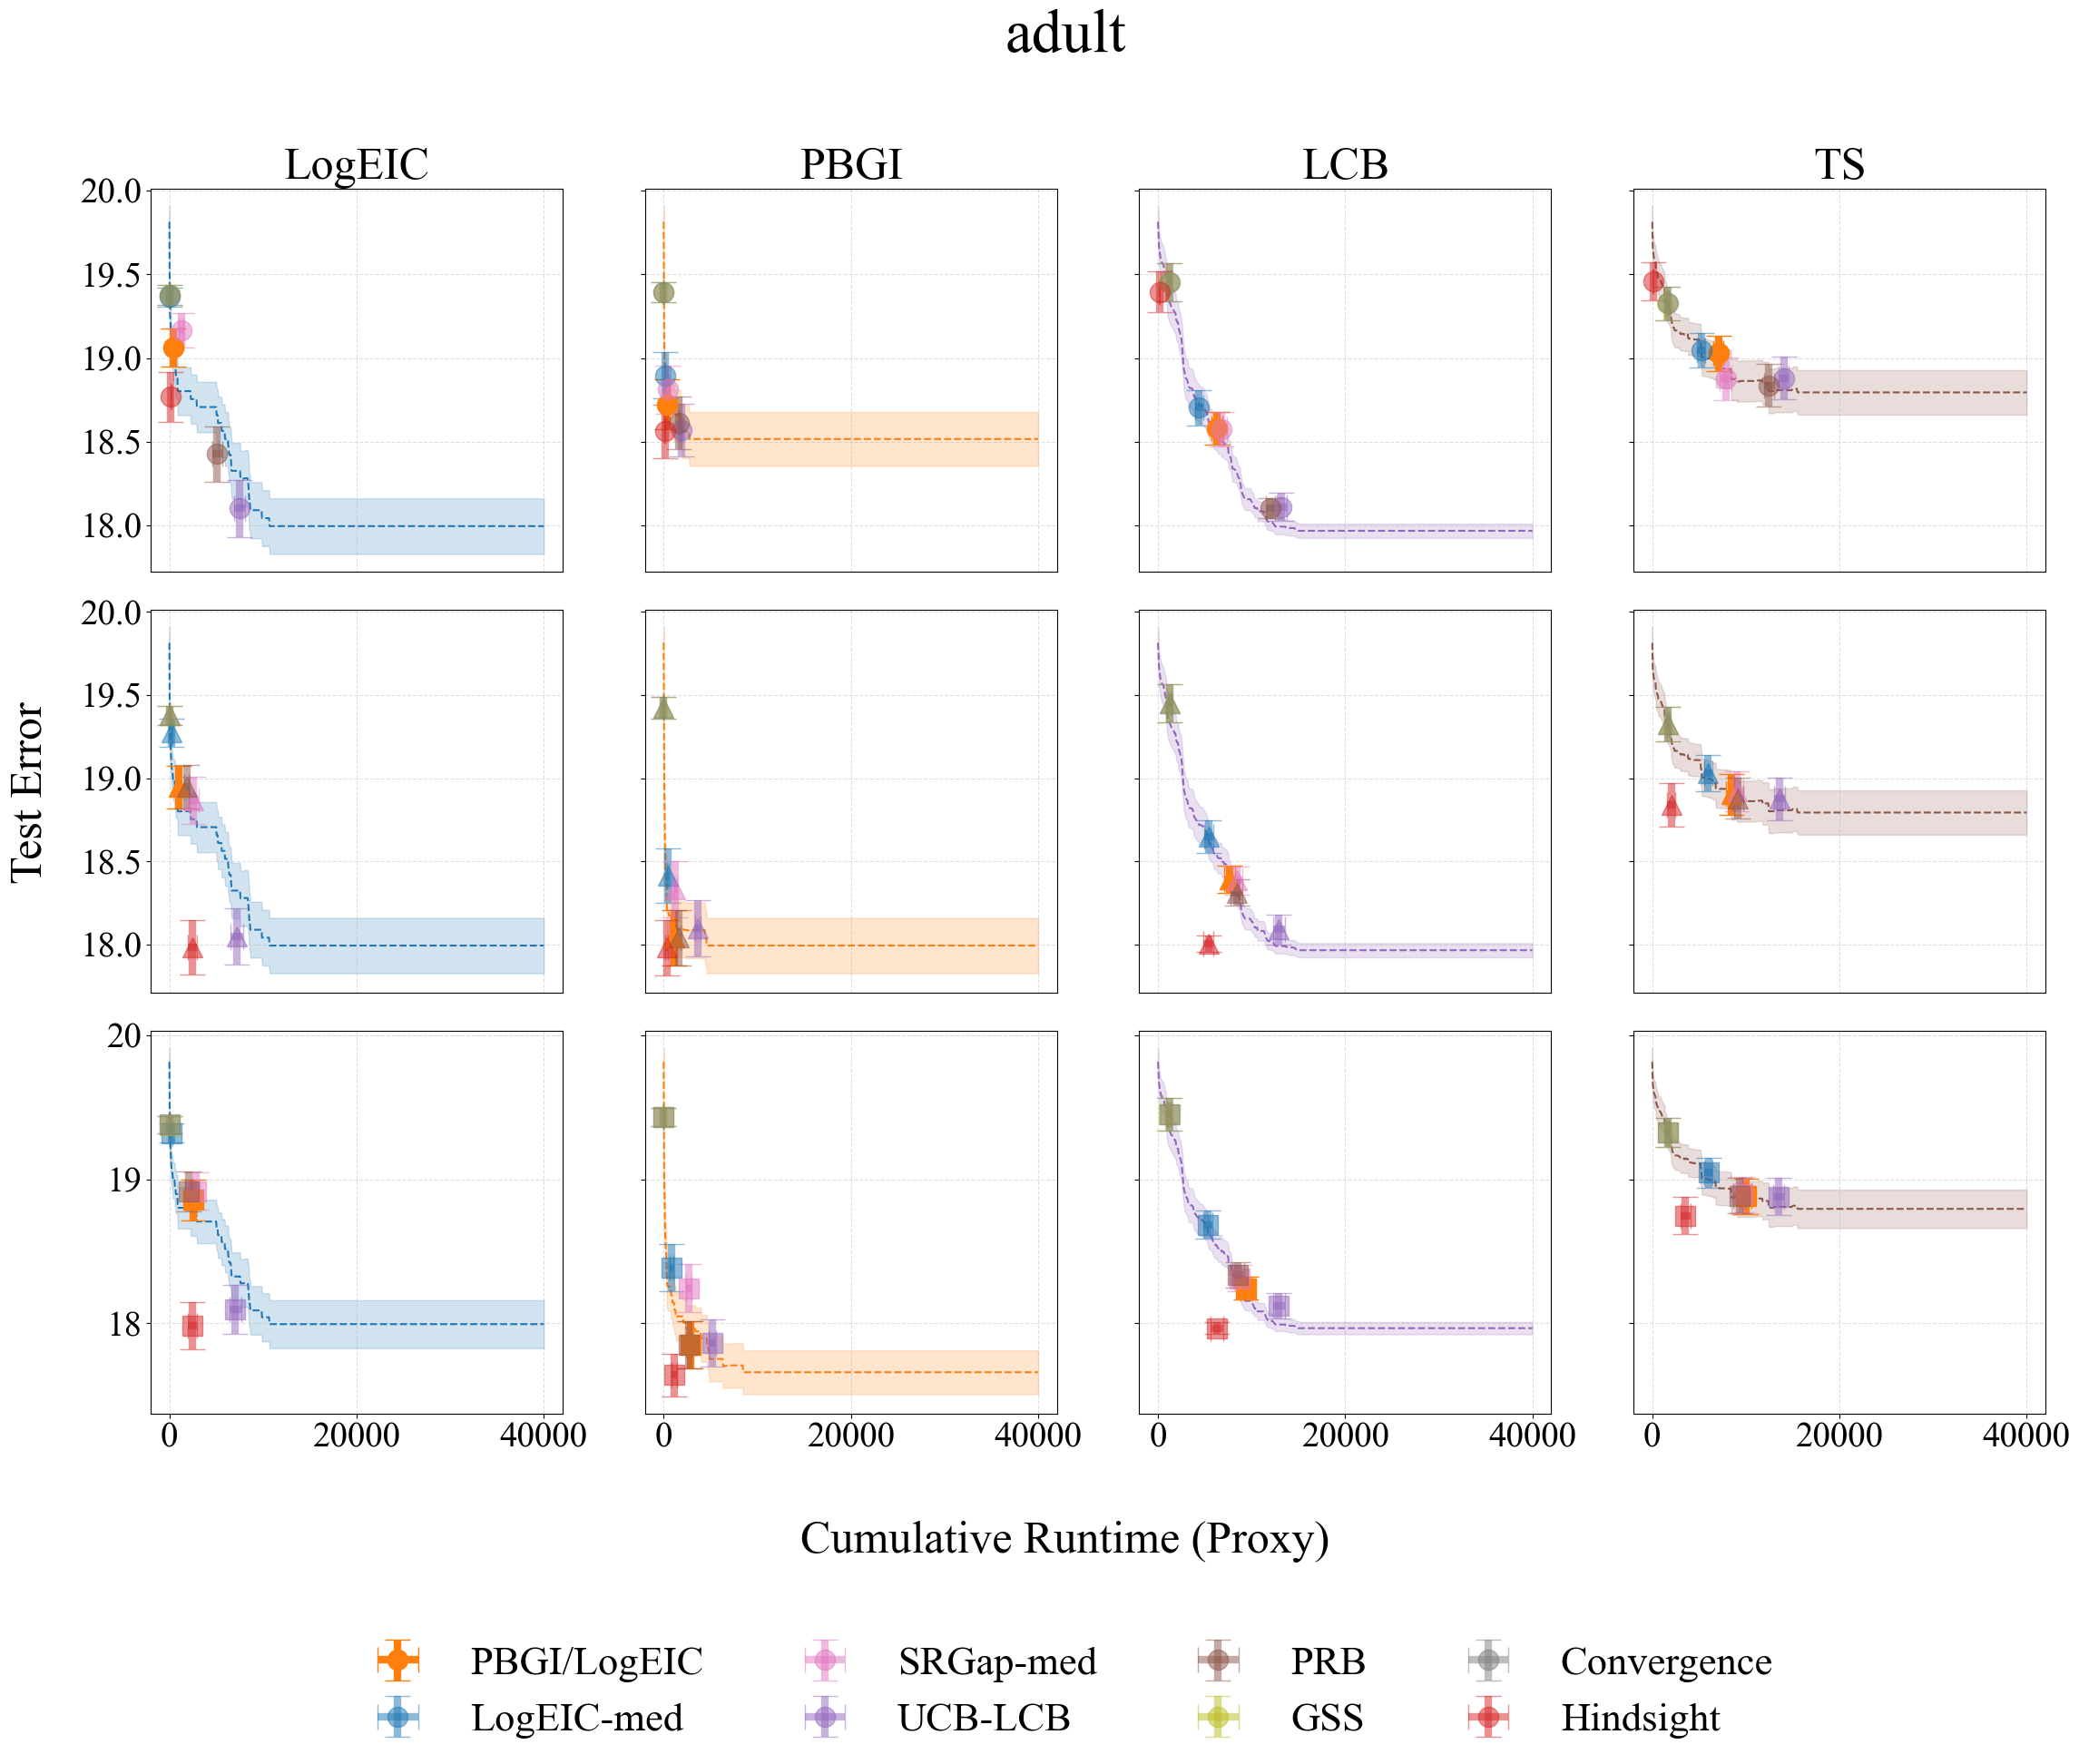

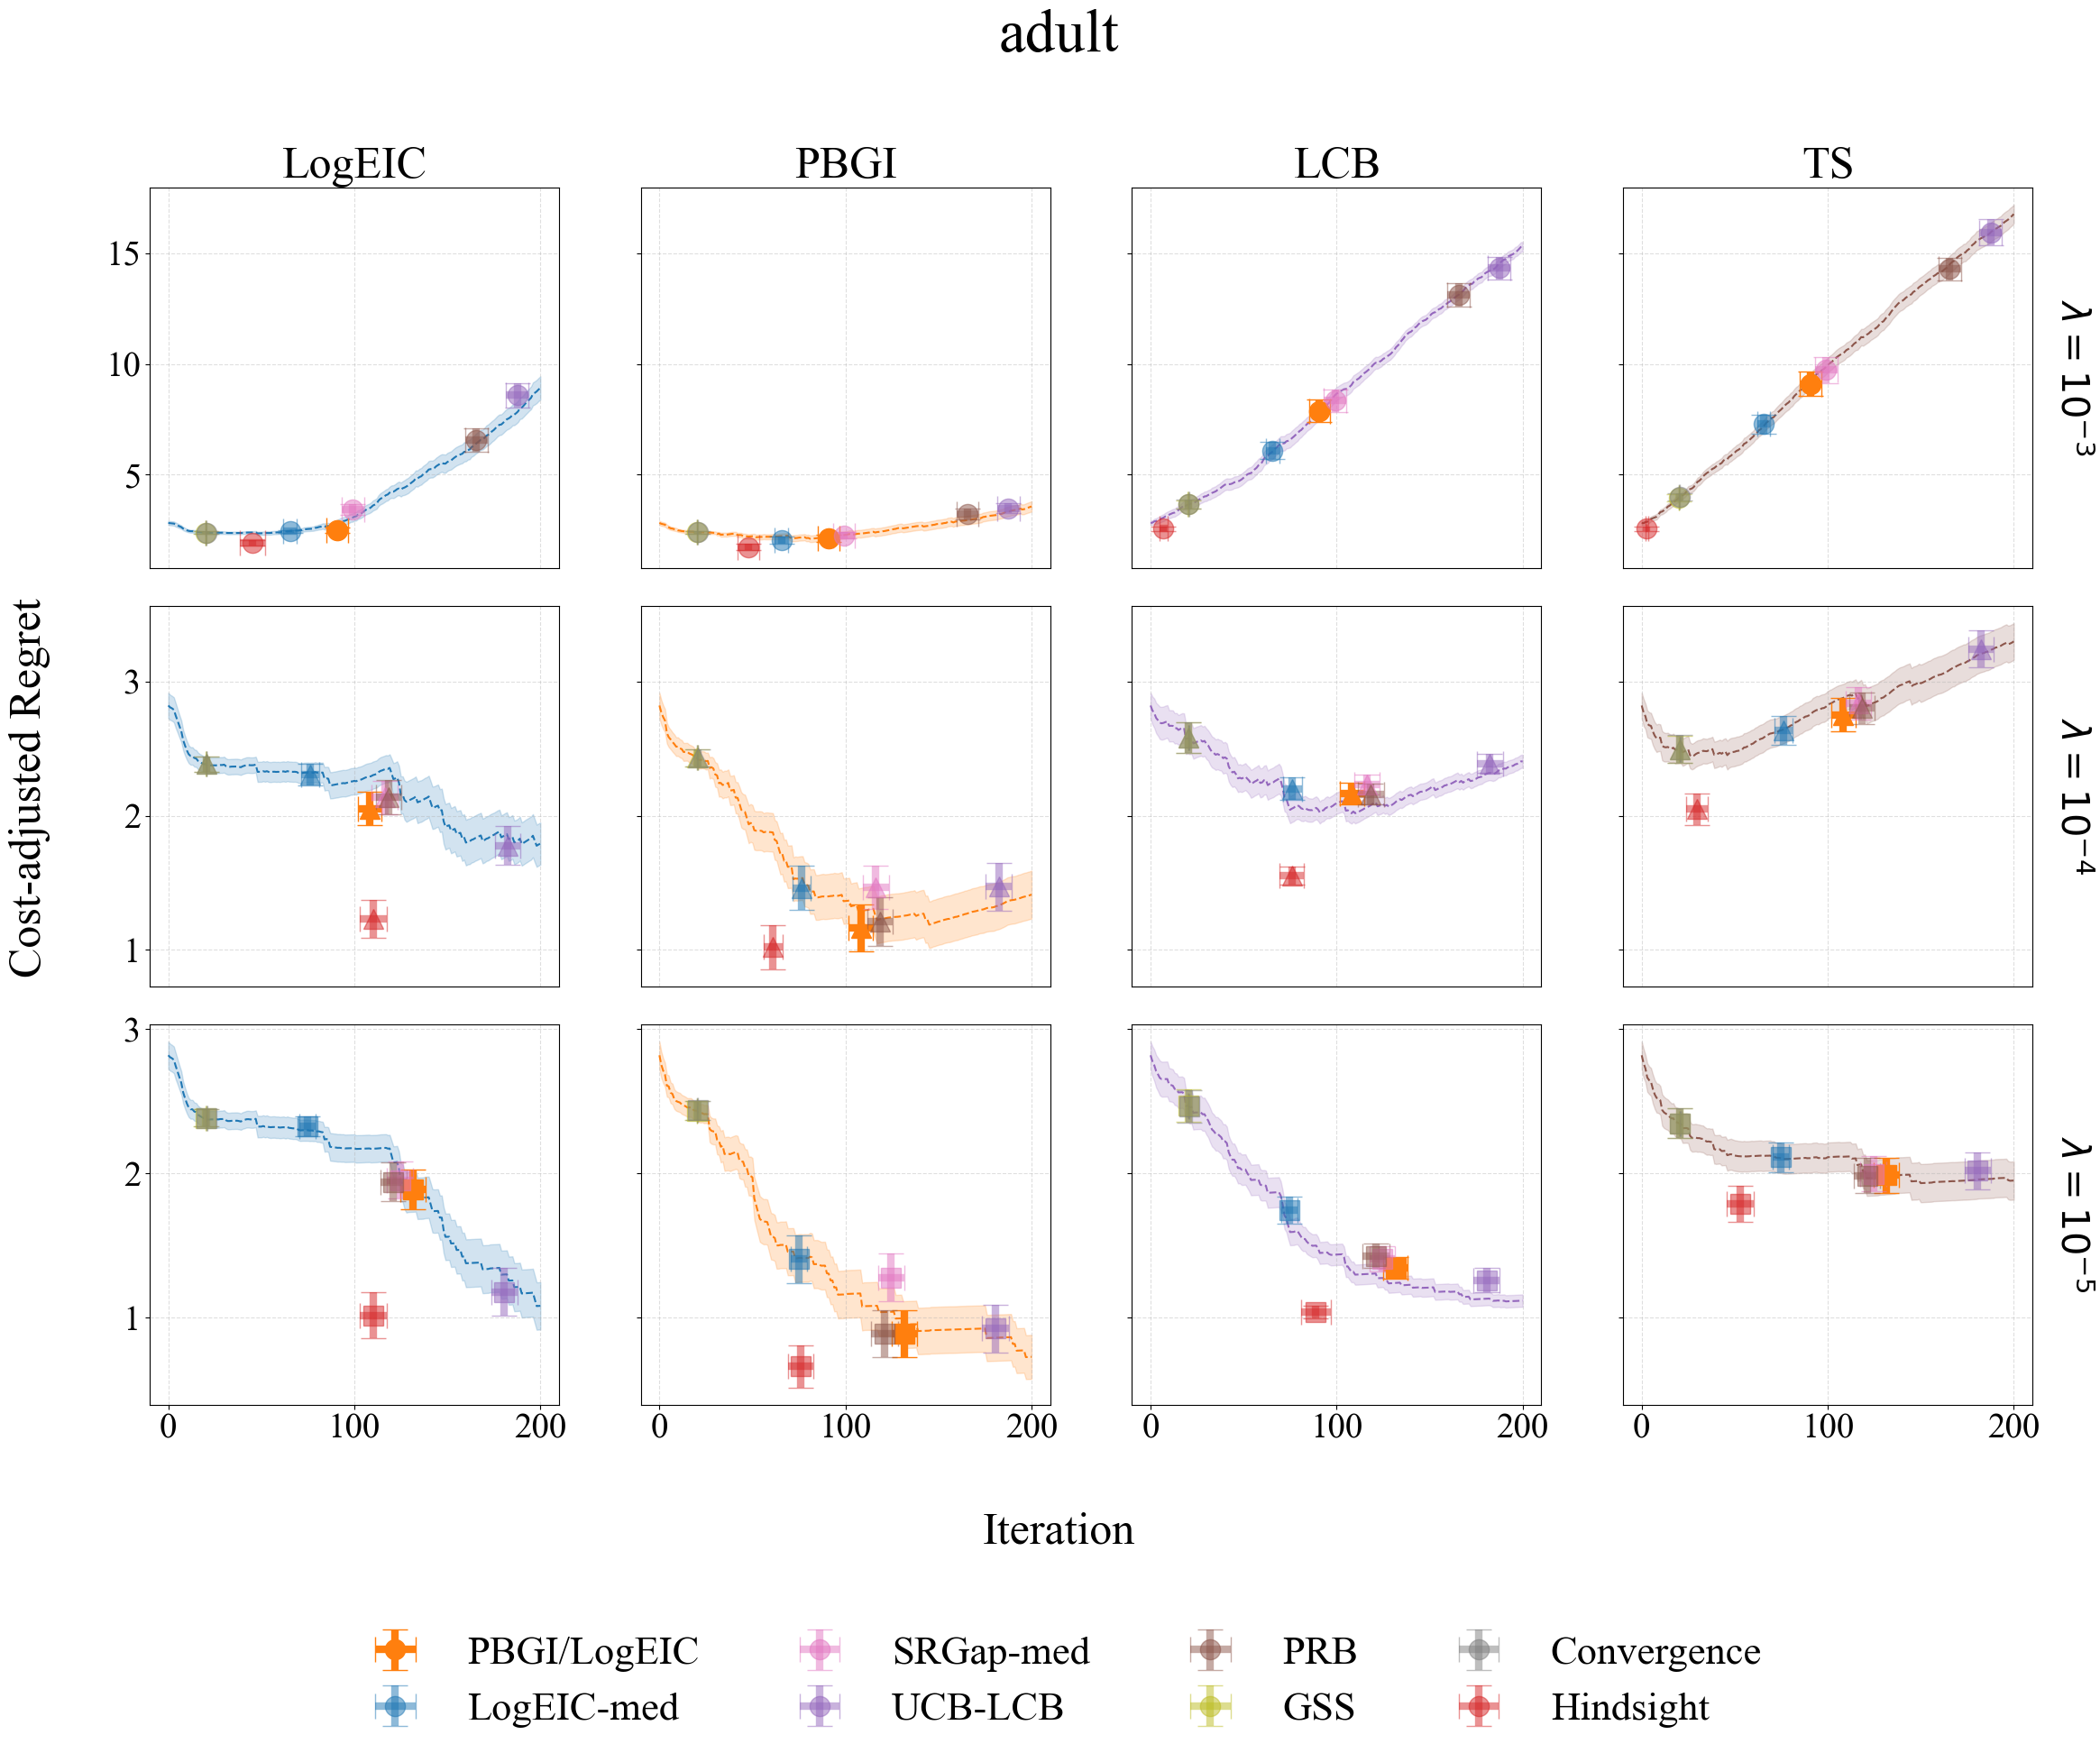

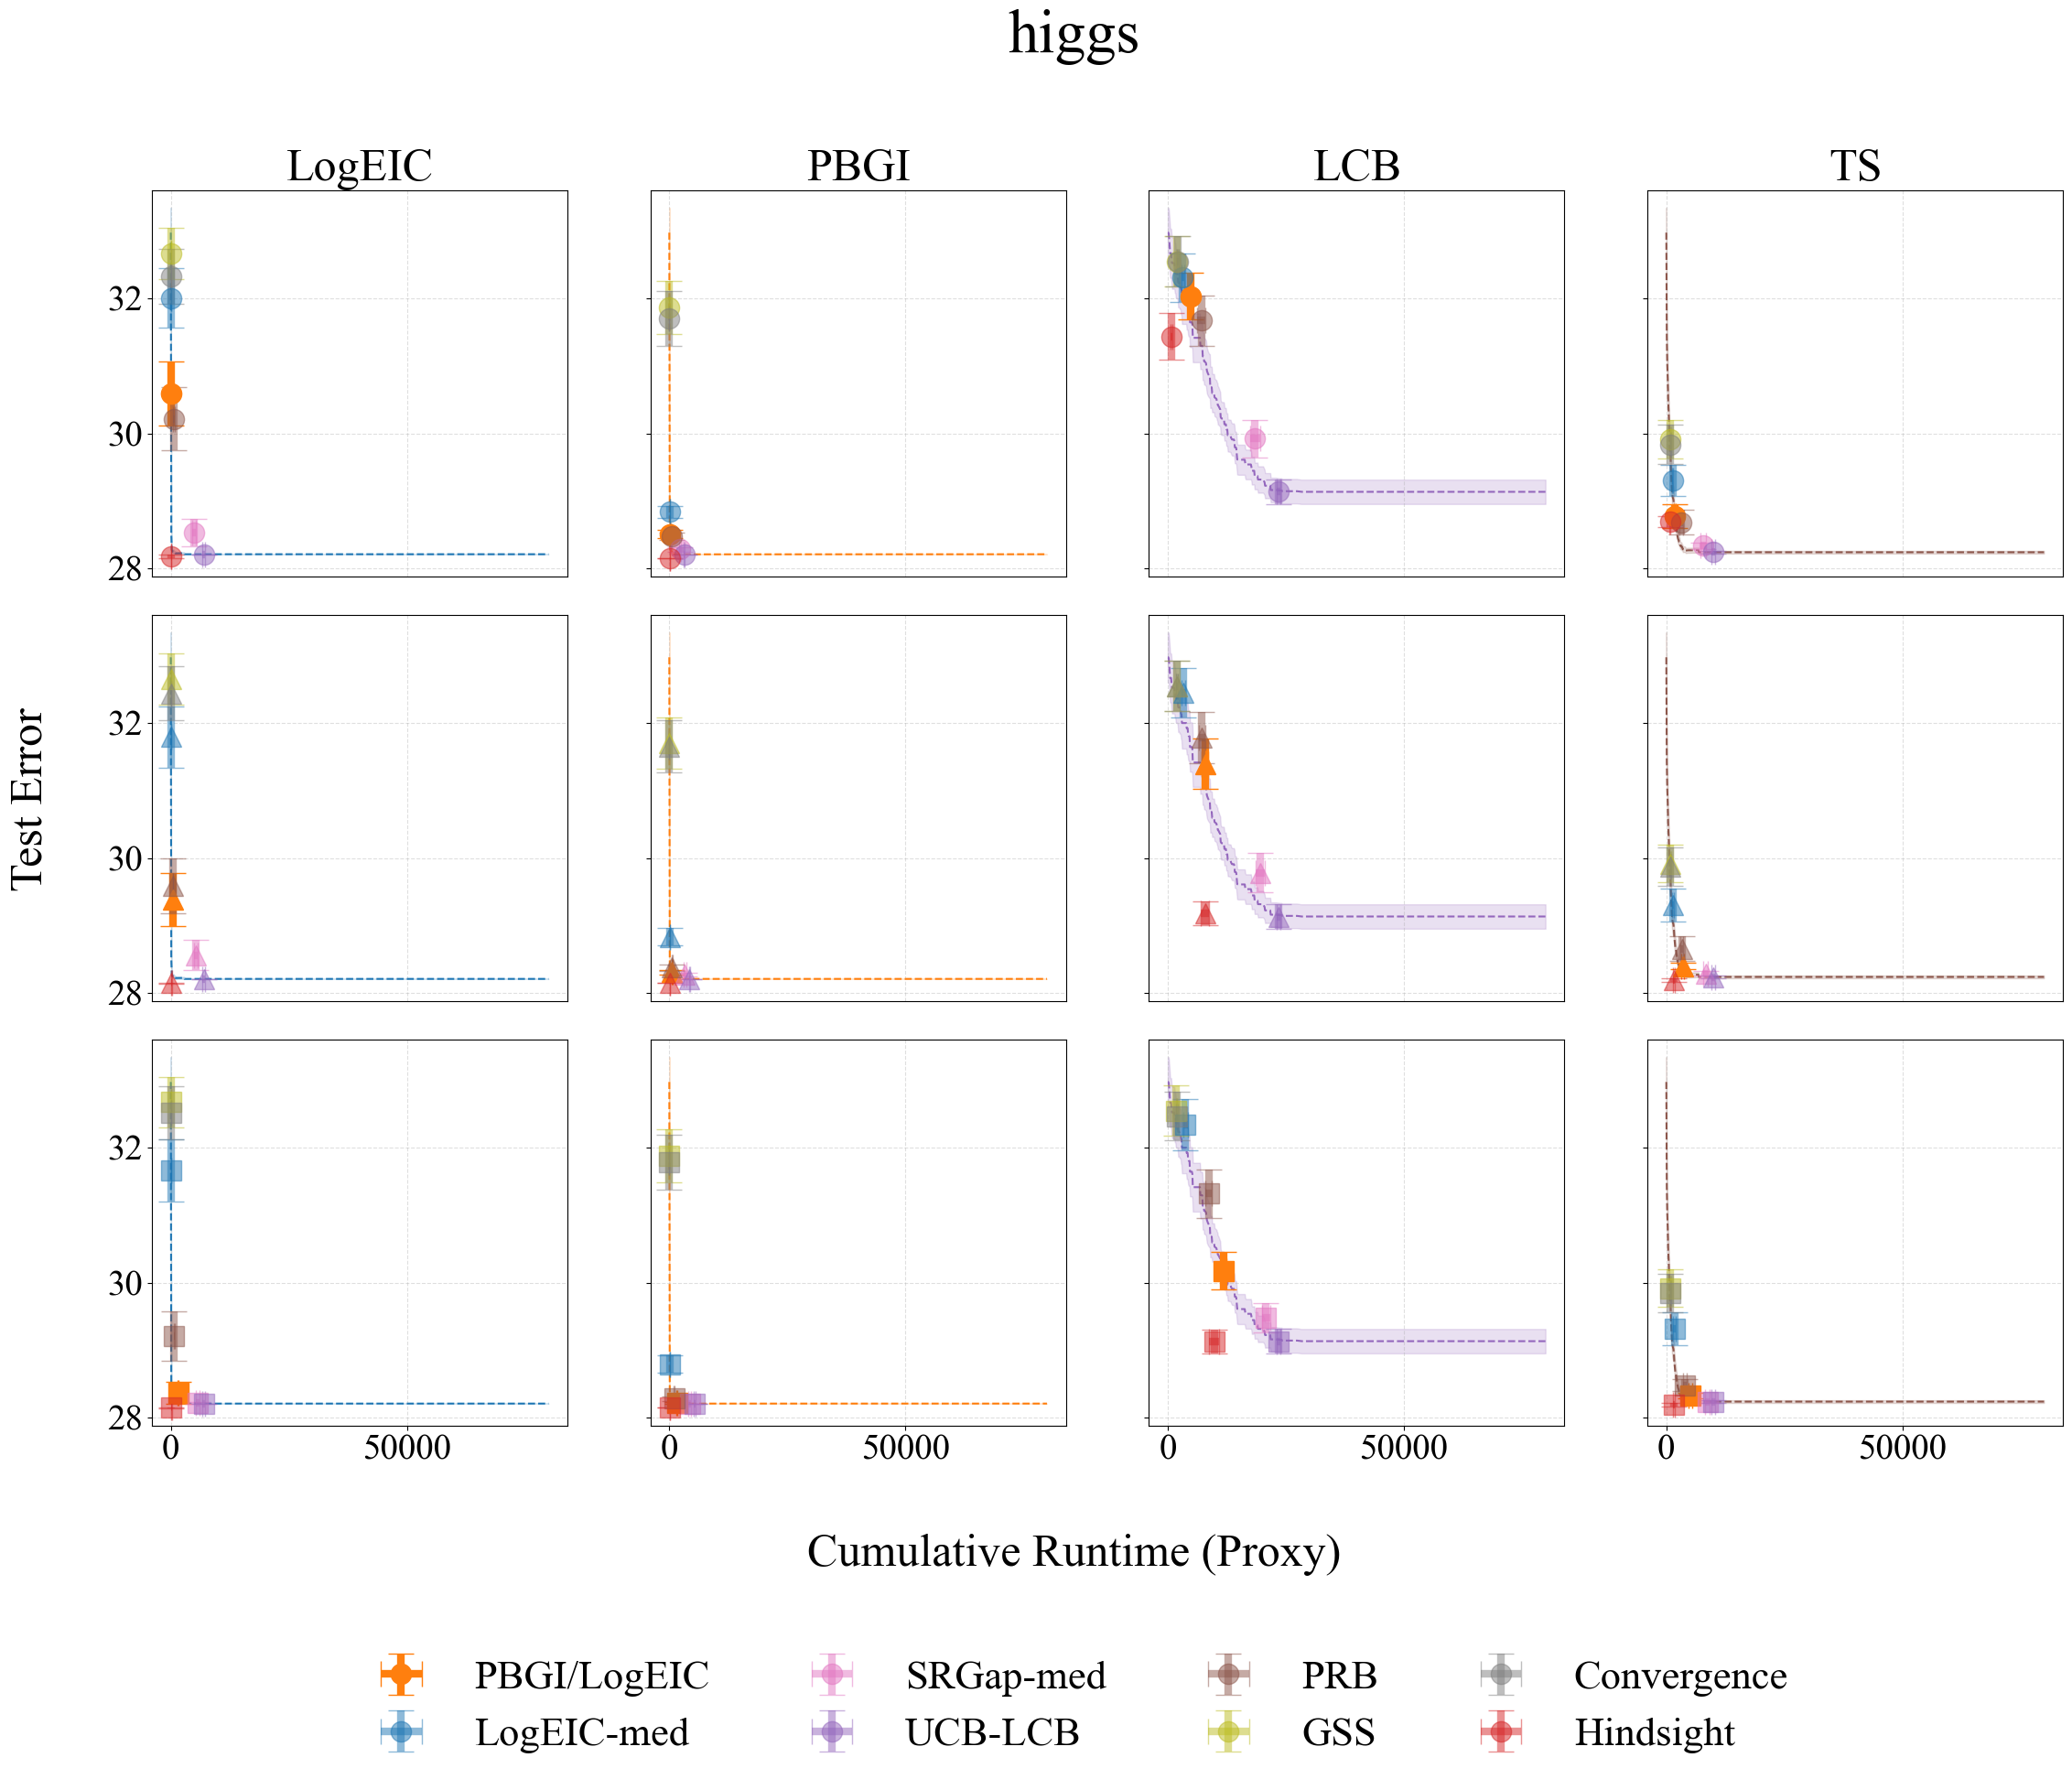

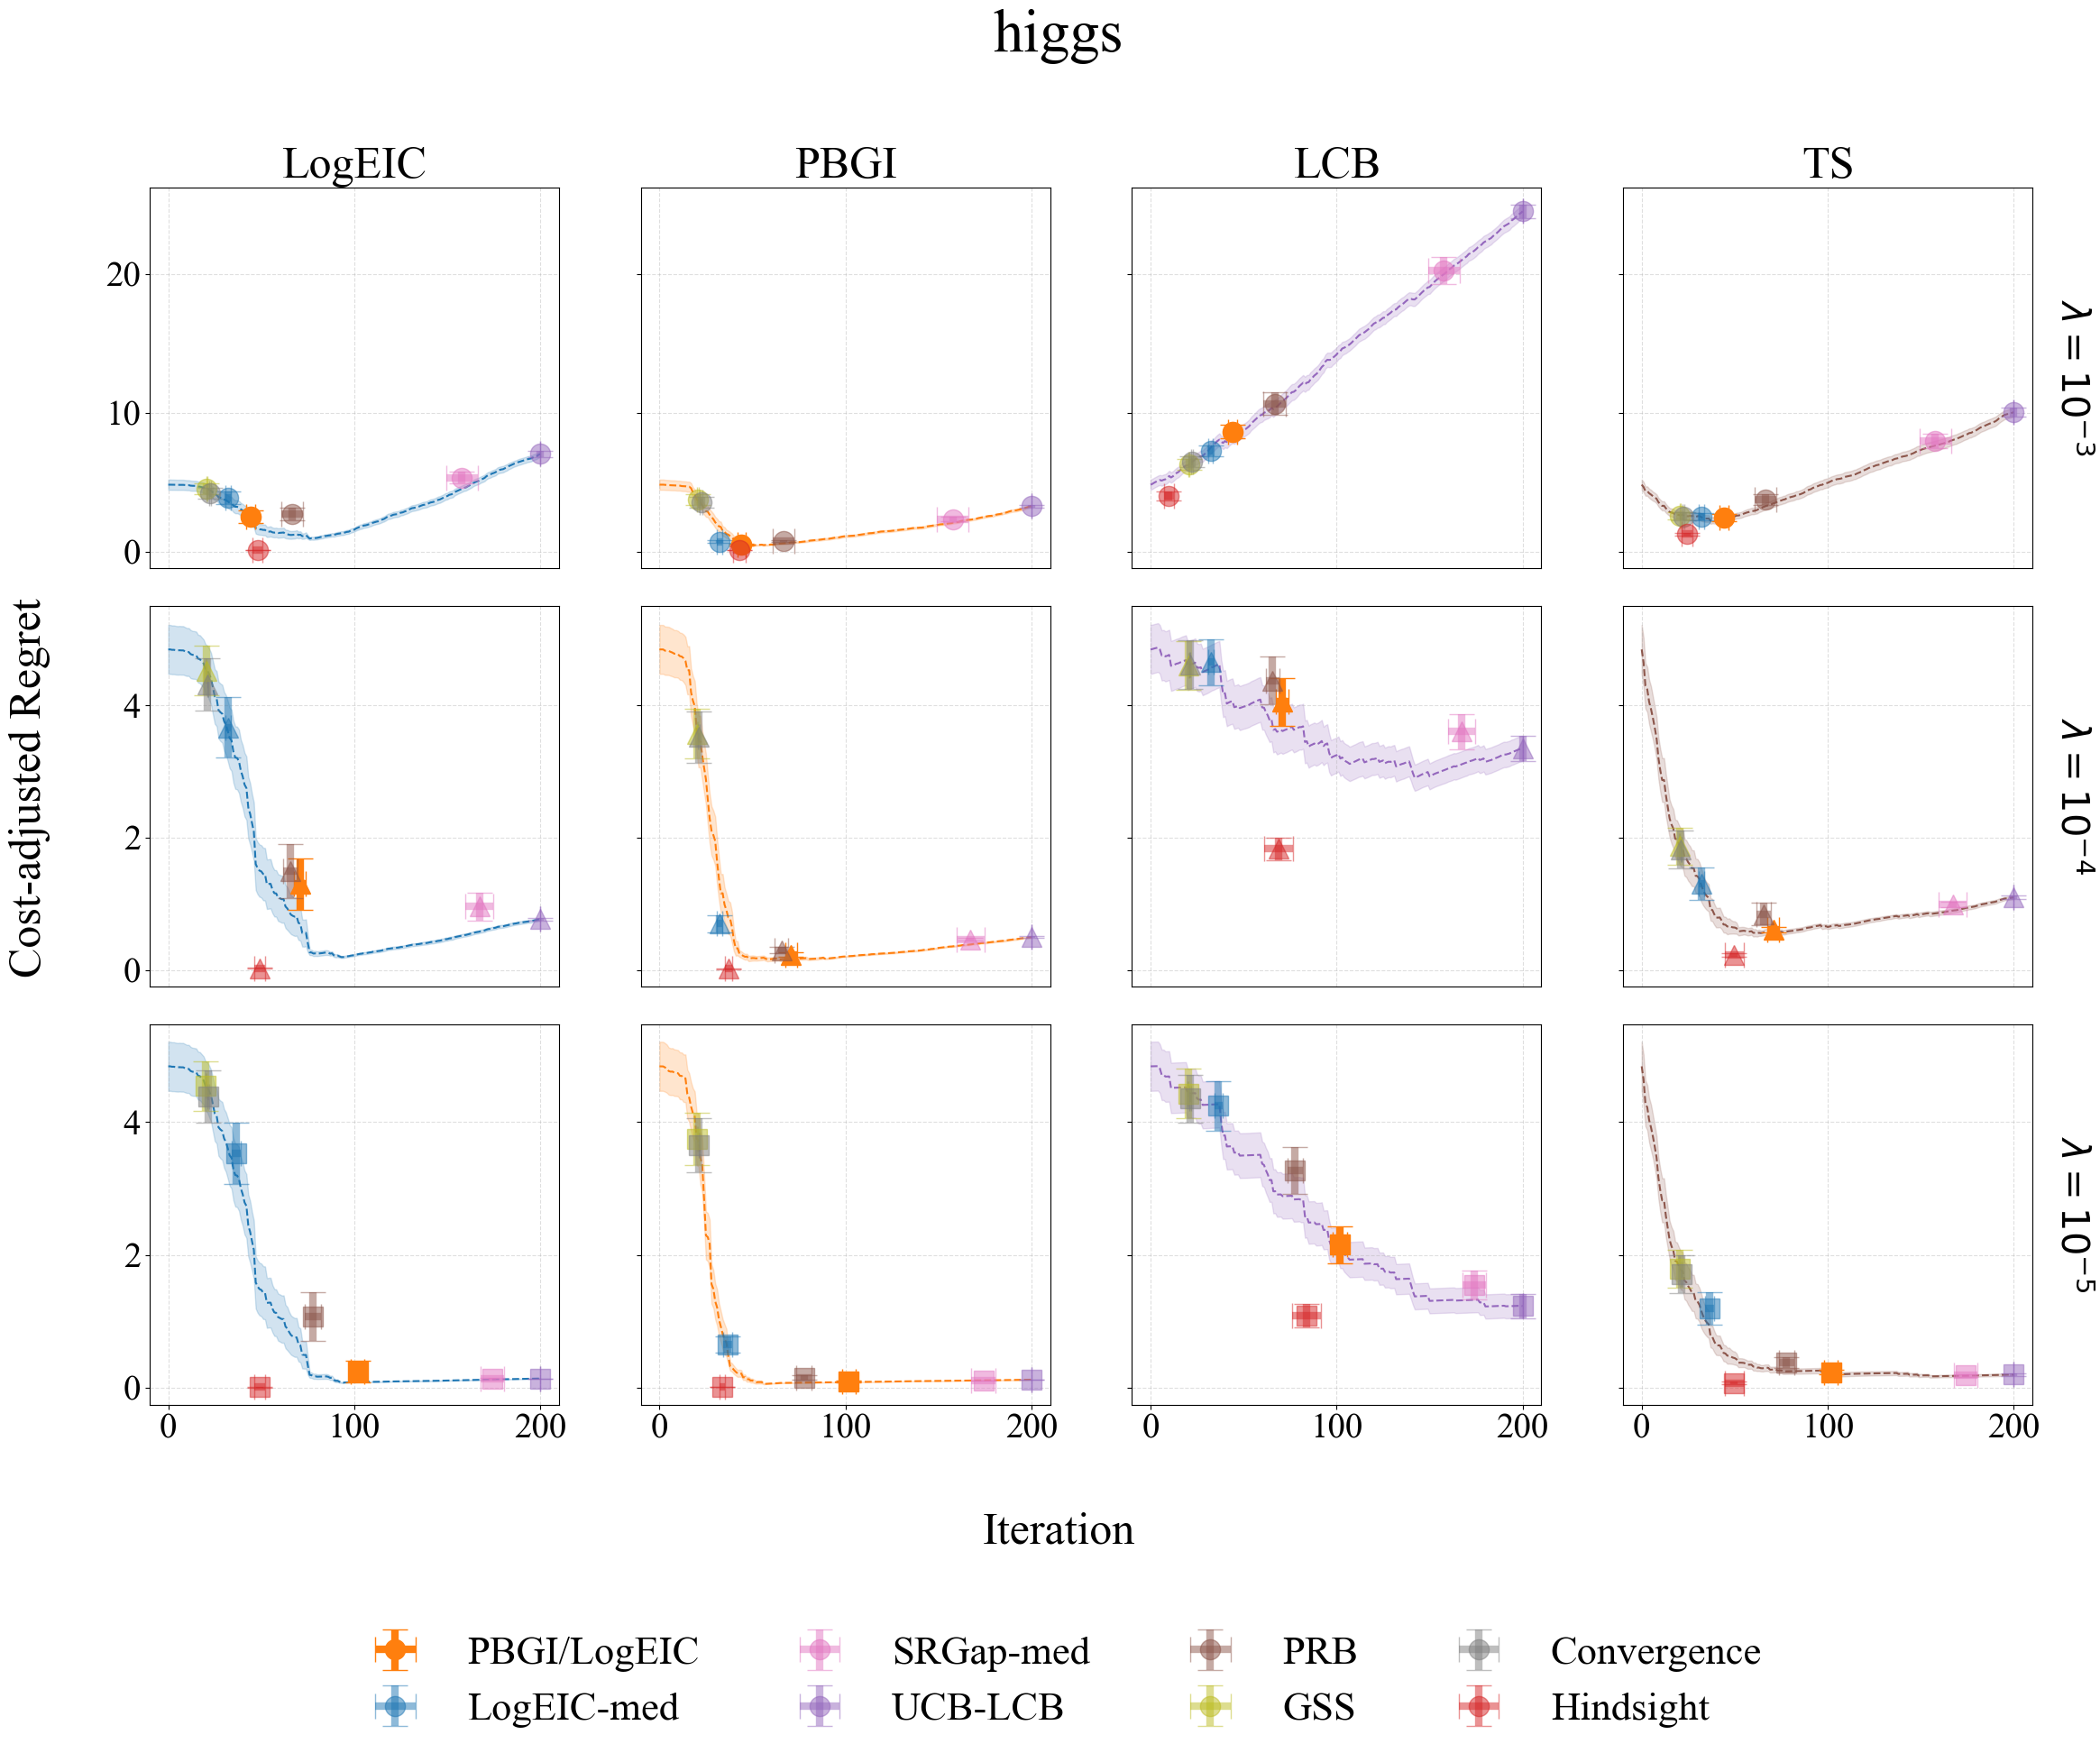

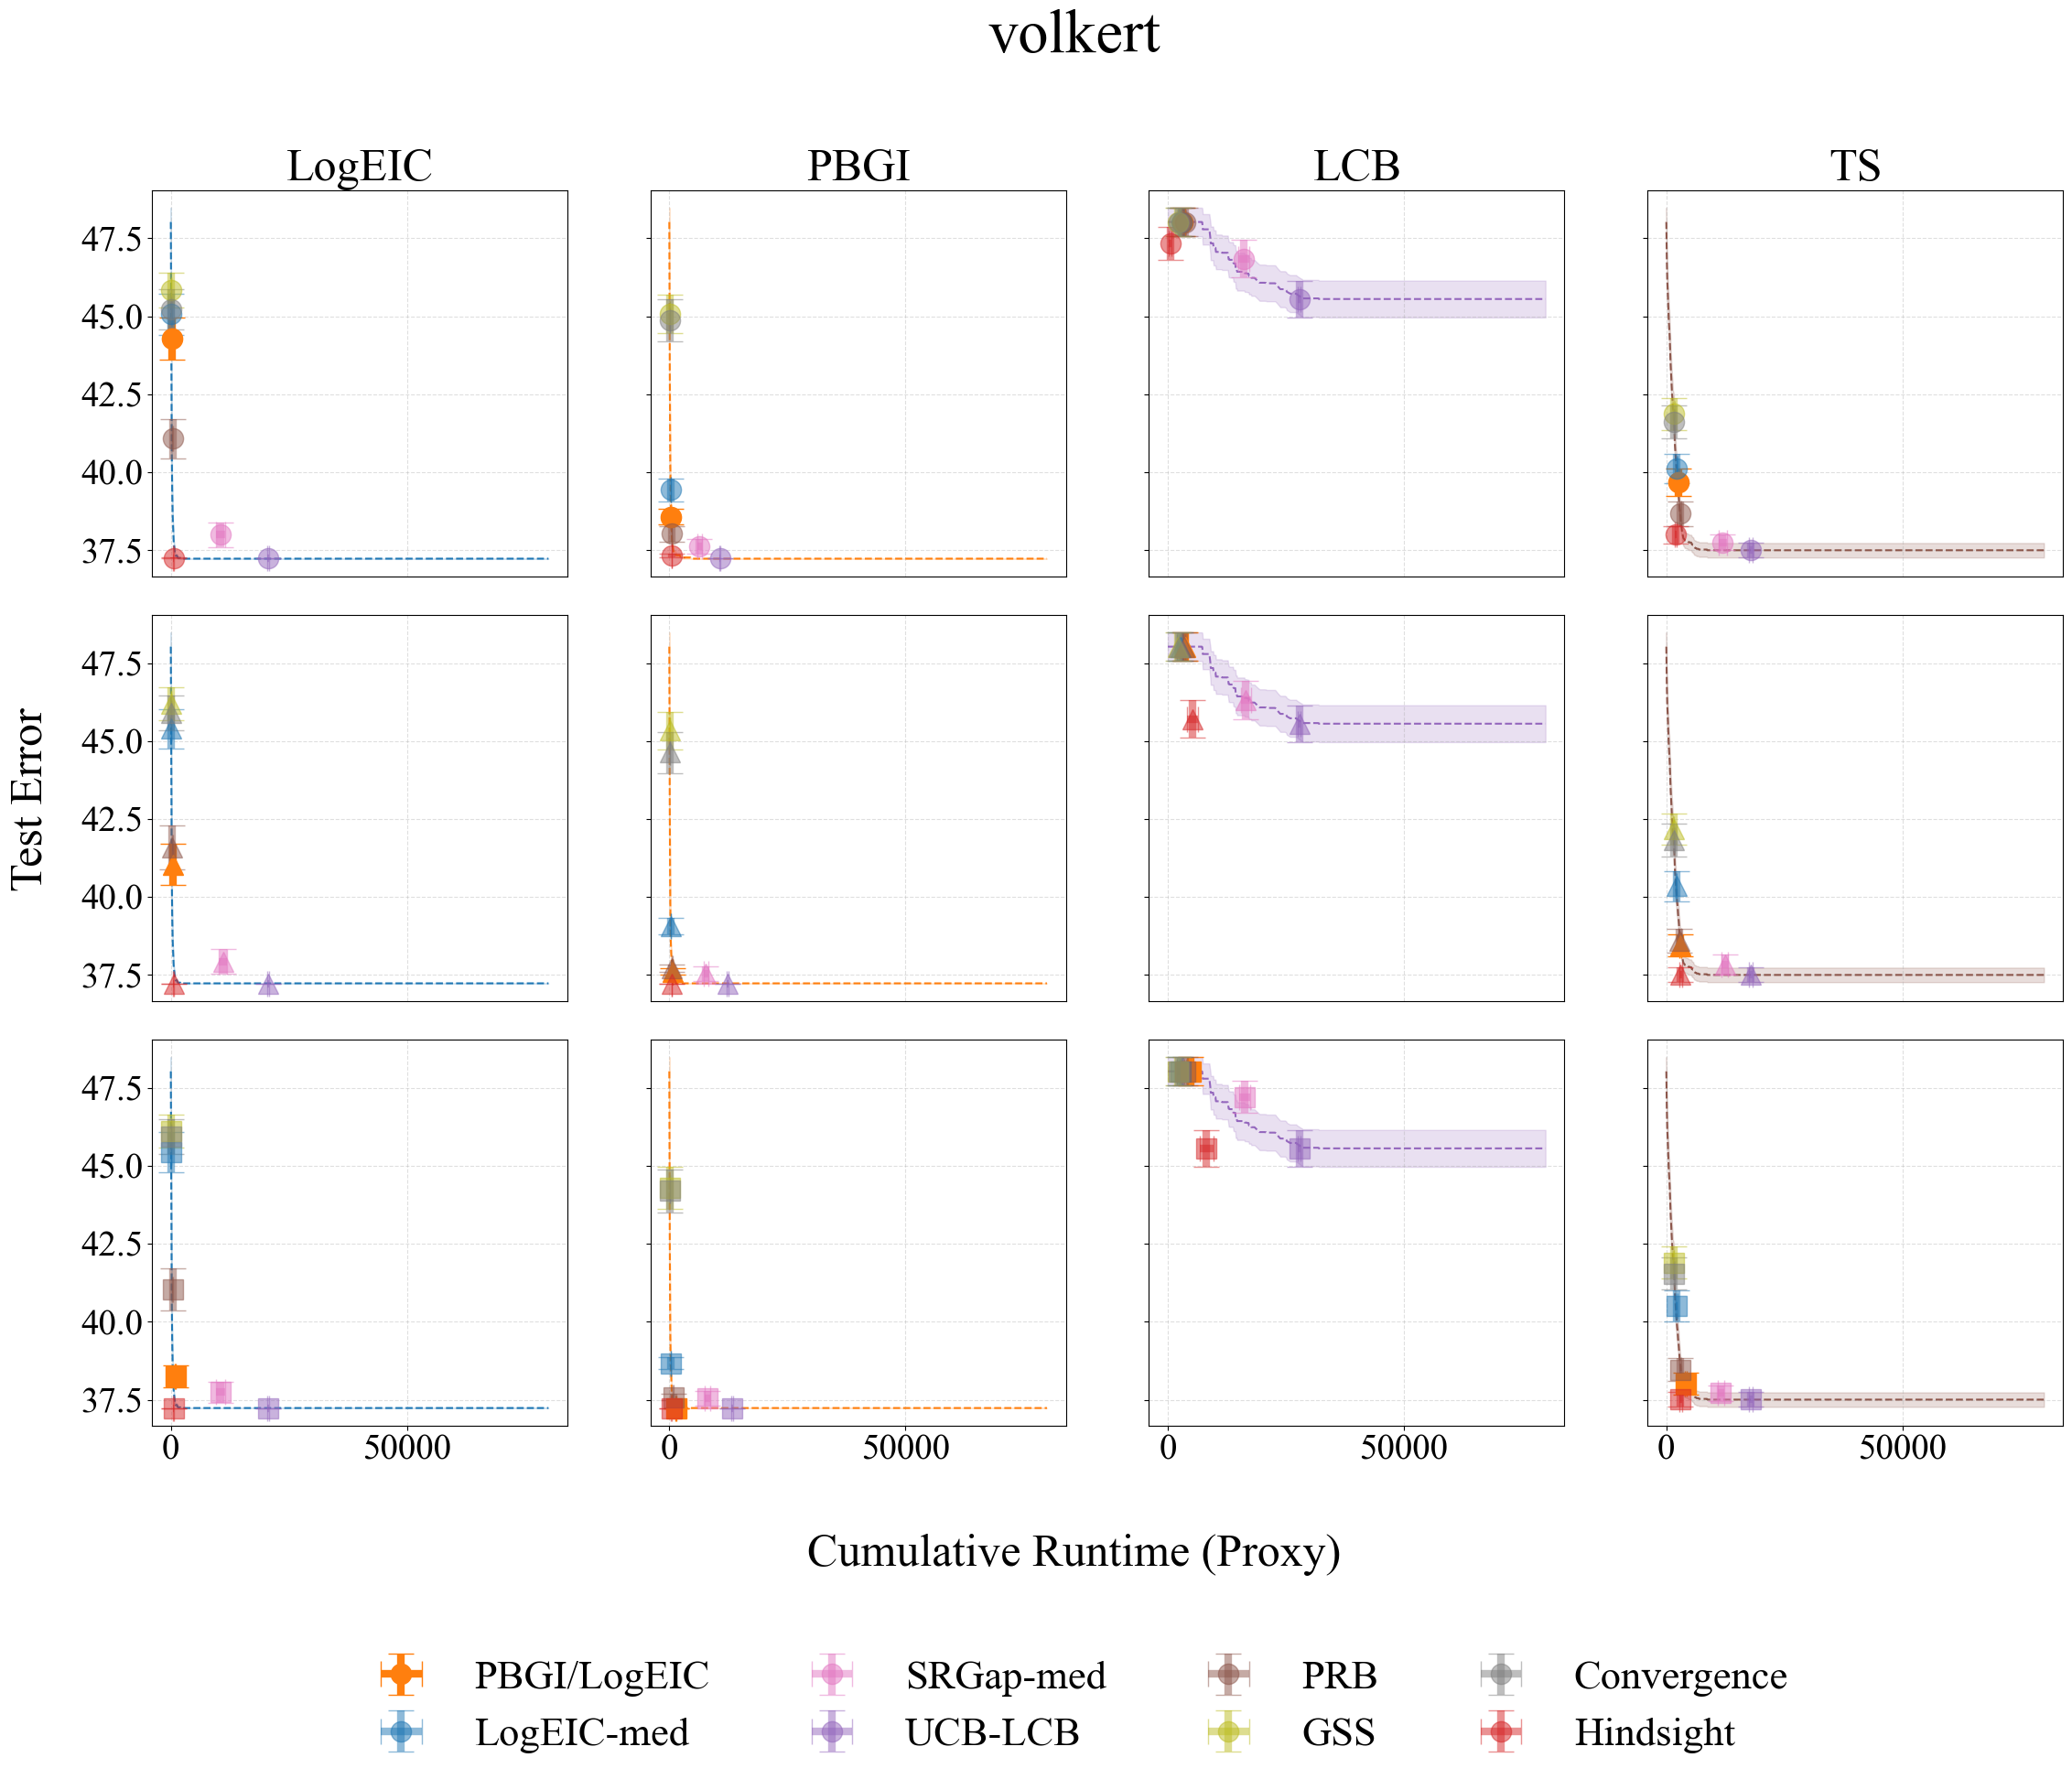

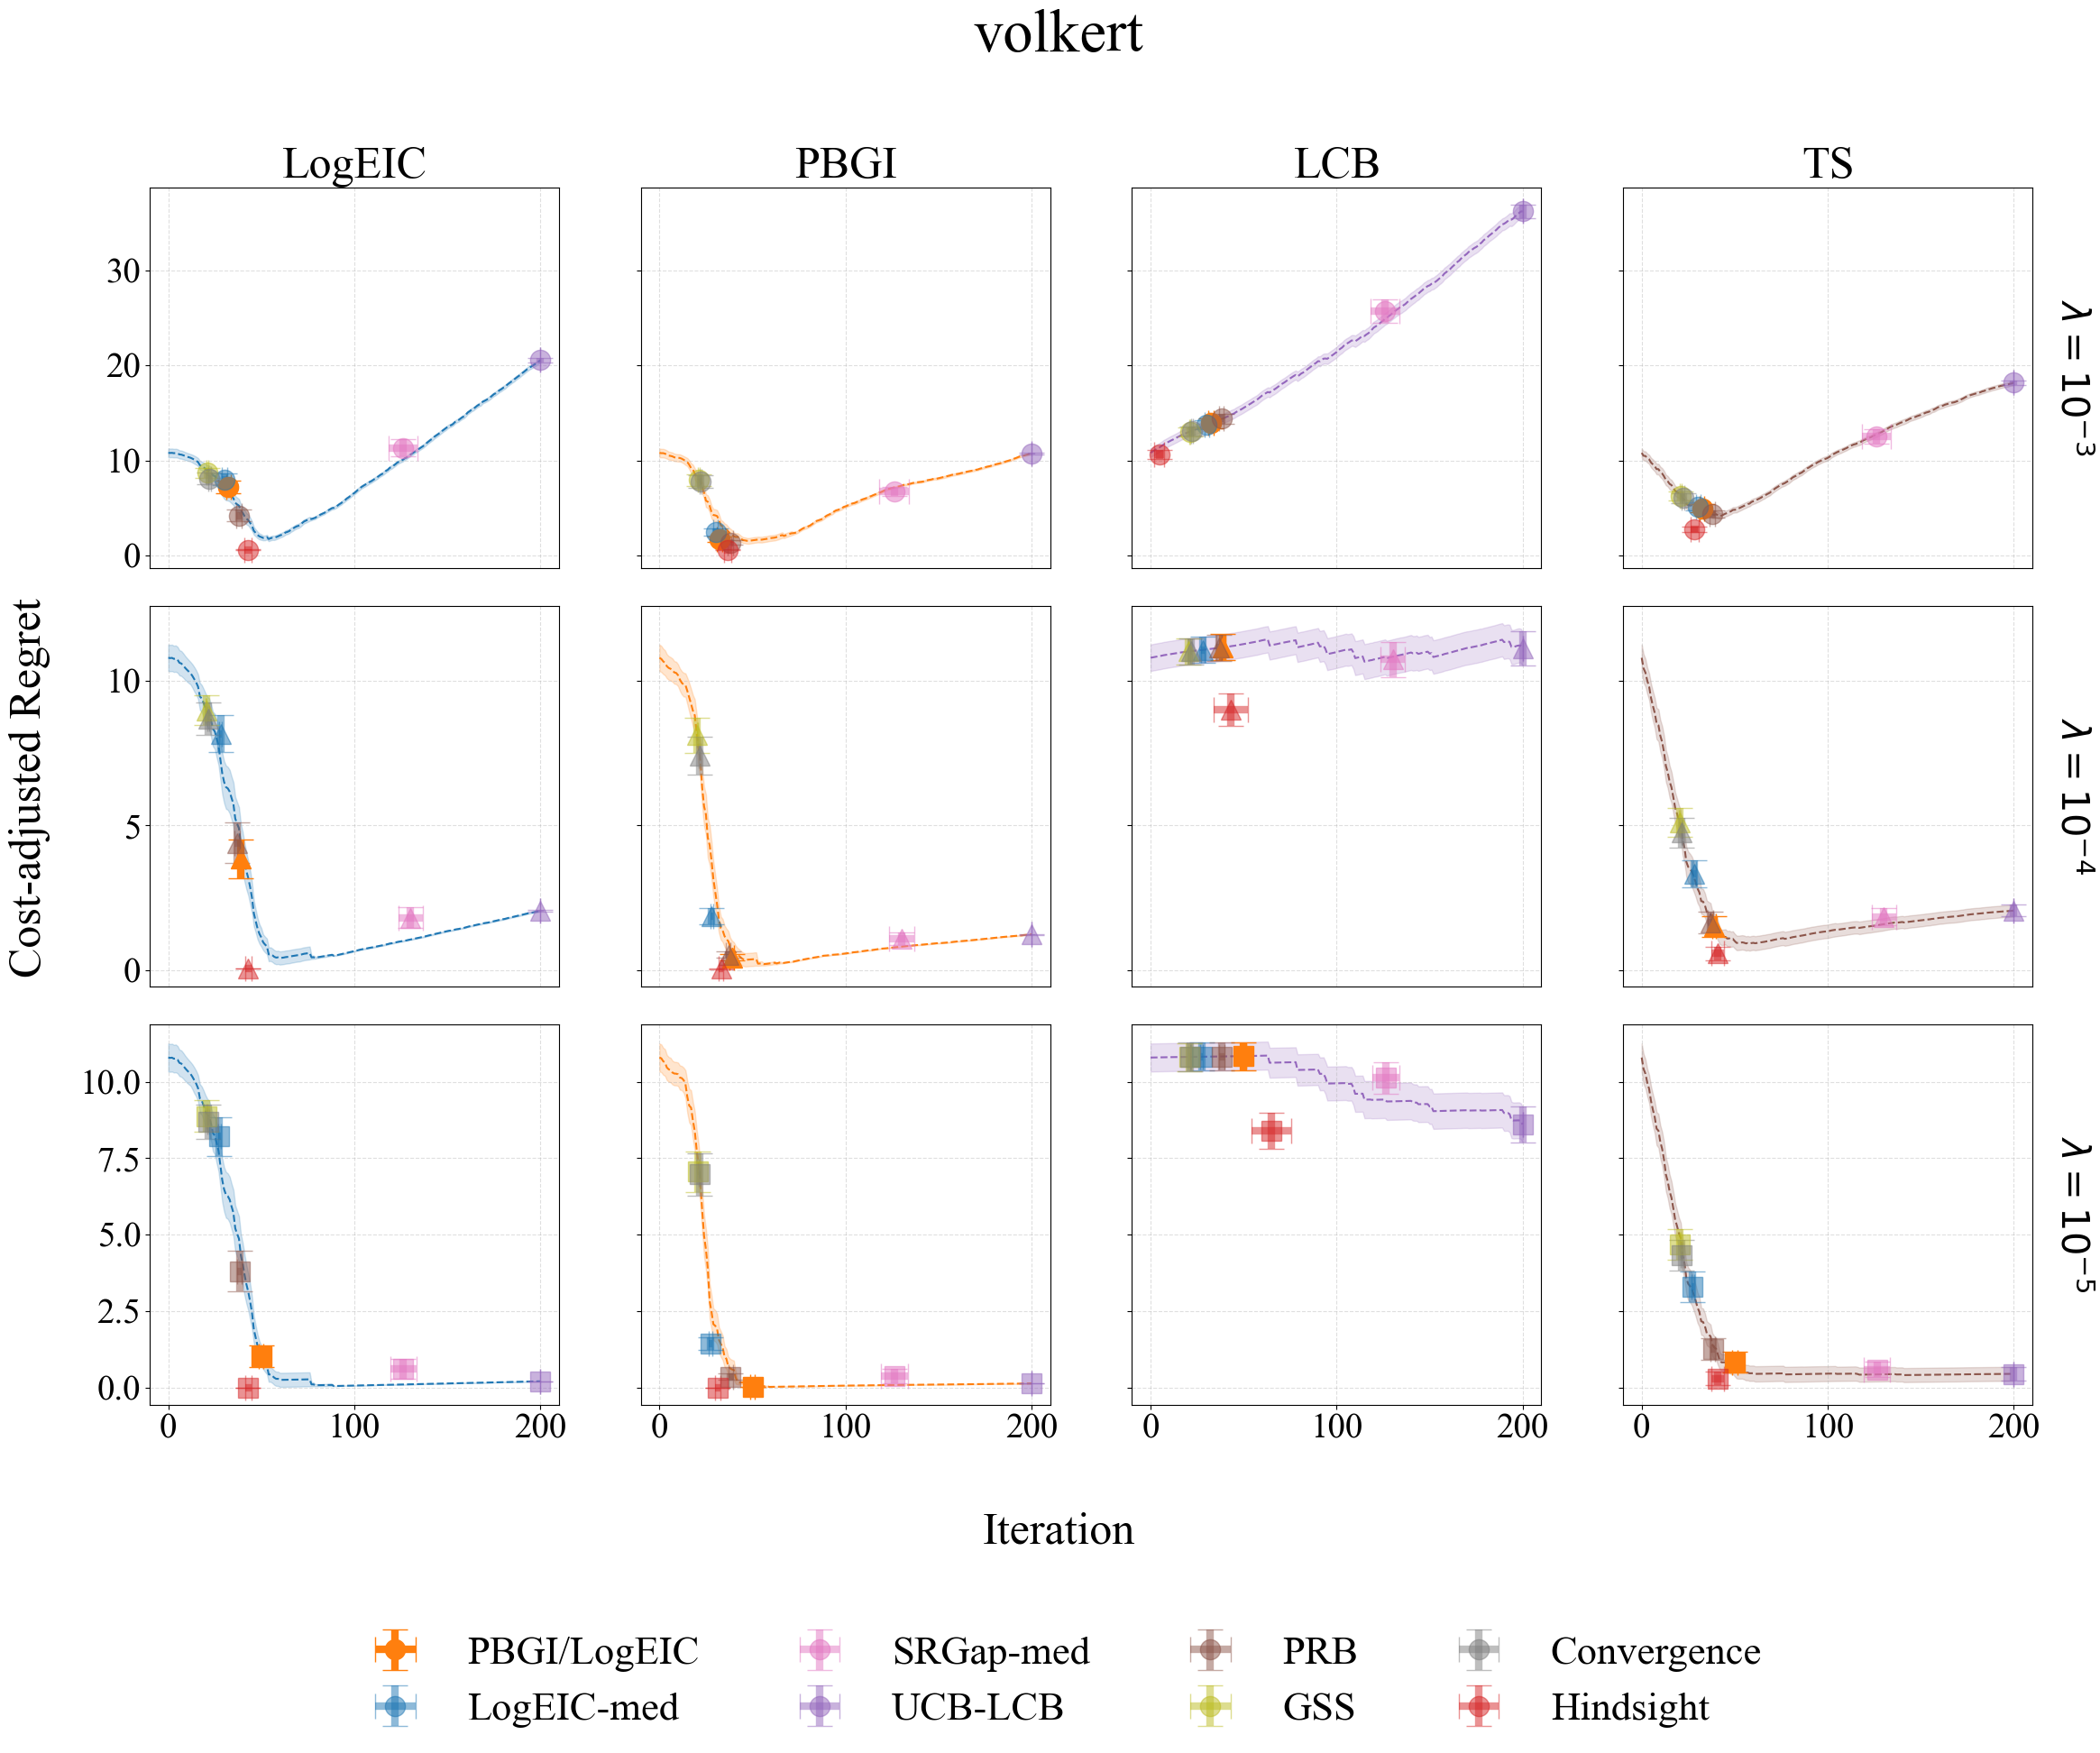

In [16]:
import numpy as np

# === User‐provided data and helper functions (assumed to exist) ===
# metrics_per_acq[d][acq_key]["estimated cumulative cost"]
# test_metrics_per_acq[d][acq_key]["final test error"]
# bench.query_best_final(dataset, "final_test_accuracy", "final_test_accuracy", 0)

# === Config ===
dataset_names = ['Fashion-MNIST', 'adult', 'higgs', 'volkert']
lambdas       = [1e-3, 1e-4, 1e-5]
acq_order     = ['LogEIC', 'PBGI', 'LCB', 'TS']
init          = 20

x_limit_per_dataset = {
    "Fashion-MNIST": 80000,
    "adult":         40000,
    "higgs":         40000,
    "volkert":       40000
}
cost_limit_per_dataset = {
    "Fashion-MNIST": 160000,
    "adult":         40000,
    "higgs":         80000,
    "volkert":       80000
}

# === Color and marker settings ===
color_dict = {
    'LogEIC':      'tab:blue',
    'LogEIC-med':  'tab:blue',
    'PBGI(1e-3)':  'tab:orange',
    'PBGI(1e-4)':  'tab:orange',
    'PBGI(1e-5)':  'tab:orange',
    'LCB':         'tab:purple',
    'UCB-LCB':     'tab:purple',
    'SRGap-med':   'tab:pink',
    'TS':          'tab:brown',
    'PRB':         'tab:brown',
    'GSS':         'tab:olive',
    'Convergence': 'tab:gray',
    'Hindsight':   'tab:red'
}
marker_dict = {
    '1e-3': 'o',
    '1e-4': '^',
    '1e-5': 's'
}

# === Build stopping_rules for each λ ===
stopping_rules = []
for lam in lambdas:
    lam_str   = f"1e-{int(round(-np.log10(lam)))}"  # “1e-3”, “1e-4”, “1e-5”
    fixed_acq = f"PBGI({lam_str})"
    marker    = marker_dict[lam_str]

    templates = [
        {
            'stp_key':      'PBGI',
            'is_hindsight': False,
            'condition_fn': (lambda i, seed, d, lam=lam, fa=fixed_acq: (
                i >= init and
                metrics_per_acq[d][fa][f"{fa} acq"][seed][i] >=
                metrics_per_acq[d][fa]["current best observed"][seed][i - 1]
            ))
        },
        # {
        #     'stp_key':      'LogEIC',
        #     'is_hindsight': False,
        #     'condition_fn': (lambda i, seed, d, lam=lam, fa=fixed_acq: (
        #         i >= init and
        #         metrics_per_acq[d][fa]["LogEIC acq"][seed][i] <= np.log(lam)
        #     ))
        # },
        {
            'stp_key':      'LogEIC-med',
            'is_hindsight': False,
            'condition_fn': (lambda i, seed, d, fa=fixed_acq: (
                i >= init and
                metrics_per_acq[d][fa]["LogEIC acq"][seed][i] <= (
                    np.log(0.01) +
                    np.nanmedian(metrics_per_acq[d][fa]["LogEIC acq"][seed][1:21])
                )
            ))
        },
        {
            'stp_key':      'SRGap-med',
            'is_hindsight': False,
            'condition_fn': (lambda i, seed, d, fa=fixed_acq: (
                i >= init and
                metrics_per_acq[d][fa]["exp min regret gap"][seed][i] <=
                0.1 * np.nanmedian(
                    metrics_per_acq[d][fa]["exp min regret gap"][seed][1:21]
                )
            ))
        },
        {
            'stp_key':      'UCB-LCB',
            'is_hindsight': False,
            'condition_fn': (lambda i, seed, d, fa=fixed_acq: (
                i >= init and
                metrics_per_acq[d][fa]["regret upper bound"][seed][i] <= 0.01
            ))
        },
        {
            'stp_key':      'PRB',
            'is_hindsight': False,
            'condition_fn': (lambda i, seed, d, fa=fixed_acq: (
                i >= init and
                metrics_per_acq[d][fa]["PRB"][seed][i] >= 0.95
            ))
        },
        {
            'stp_key':      'GSS',
            'is_hindsight': False,
            'condition_fn': (lambda i, seed, d, fa=fixed_acq: (
                i >= init and (
                    (np.nanpercentile(
                        metrics_per_acq[d][fa]["current best observed"][seed][:i+1], 75
                     ) -
                     np.nanpercentile(
                        metrics_per_acq[d][fa]["current best observed"][seed][:i+1], 25
                     )) == 0
                ) or (
                    ((metrics_per_acq[d][fa]["current best observed"][seed][i - 5] -
                      metrics_per_acq[d][fa]["current best observed"][seed][i]) /
                     (np.nanpercentile(
                        metrics_per_acq[d][fa]["current best observed"][seed][:i+1], 75
                     ) -
                      np.nanpercentile(
                        metrics_per_acq[d][fa]["current best observed"][seed][:i+1], 25
                     ))
                    ) <= 0.01
                )
            ))
        },
        {
            'stp_key':      'Convergence',
            'is_hindsight': False,
            'condition_fn': (lambda i, seed, d, fa=fixed_acq: (
                i >= init and
                metrics_per_acq[d][fa]["current best observed"][seed][i] ==
                metrics_per_acq[d][fa]["current best observed"][seed][i - 5]
            ))
        },
        {
            'stp_key':      'Hindsight',
            'is_hindsight': True,
            'condition_fn': None
        }
    ]

    for temp in templates:
        rule = {
            'acq_key':      fixed_acq,
            'stp_key':      temp['stp_key'],
            'is_hindsight': temp['is_hindsight'],
            'marker':       marker,
            'color':        color_dict.get(temp['stp_key'], color_dict[fixed_acq]),
            'label':        'PBGI/LogEIC' if temp['stp_key'] == 'PBGI' else temp['stp_key']
        }
        if temp['condition_fn'] is not None:
            rule['condition_fn'] = temp['condition_fn']
        stopping_rules.append(rule)

# === Plotting ===
for d in dataset_names:
    best_acc   = best_acc_per_dataset[d]
    best_error = 100. - best_acc

    # === 1) Test error vs estimated cumulative cost ===
    fig, axes = plt.subplots(3, 4, figsize=(24, 18), sharey="row")
    fig.suptitle(f"{d}", fontsize=48)
    for i, lam in enumerate(lambdas):
        lam_str = f"1e-{int(round(-np.log10(lam)))}"

        for j in range(4):
            acq = acq_order[j]
            fixed_acq = f"PBGI({lam_str})" if acq == 'PBGI' else acq
            ax = axes[i, j]

            # === Mean test error curve ===
            cost_grid = np.linspace(0, cost_limit_per_dataset[d], 801)
            curves = []
            for seed in range(len(metrics_per_acq[d][fixed_acq]["estimated cumulative cost"])):
                c = np.array(metrics_per_acq[d][fixed_acq]["estimated cumulative cost"][seed])
                e = np.array(metrics_per_acq[d][fixed_acq]["final test error"][seed])
                idx = np.argsort(c)
                curves.append(np.interp(cost_grid, c[idx], e[idx]))
            curves = np.vstack(curves)
            mean_c = curves.mean(axis=0)
            sem_c  = curves.std(axis=0) / np.sqrt(curves.shape[0])

            ax.plot(cost_grid, mean_c, linestyle='--', color=color_dict[fixed_acq])
            ax.fill_between(cost_grid, mean_c - sem_c, mean_c + sem_c, color=color_dict[fixed_acq], alpha=0.2)

            # === Stopping rule overlays ===
            for rule in stopping_rules:
                # Only use rules from the correct lambda
                if rule['acq_key'] != f"PBGI({lam_str})":
                    continue

                stop_vals = []
                stop_costs = []
                for seed in range(curves.shape[0]):
                    errs = metrics_per_acq[d][fixed_acq]["final test error"][seed]
                    costs = metrics_per_acq[d][fixed_acq]["estimated cumulative cost"][seed]
                    if rule['is_hindsight']:
                        regs = np.array(errs) - best_error + lam * np.array(costs)
                        idx = np.argmin(regs)
                    else:
                        idx = next((k for k in range(init, len(errs)) if rule['condition_fn'](k, seed, d)), len(errs) - 1)
                    stop_vals.append(errs[idx])
                    stop_costs.append(costs[idx])

                mx = np.mean(stop_costs)
                my = np.mean(stop_vals)
                sx = np.std(stop_costs) / np.sqrt(len(stop_costs))
                sy = np.std(stop_vals) / np.sqrt(len(stop_vals))

                alpha = 1.0 if rule['stp_key'] == 'PBGI' else 0.5
                ax.errorbar(mx, my, xerr=sx, yerr=sy,
                            fmt=rule['marker'],
                            markersize=16,
                            linewidth=6,
                            color=rule['color'],
                            capsize=10,
                            alpha=alpha,
                            label=rule['label'])

            if i == 0:
                ax.set_title(acq, fontsize=36)  # only first row
            ax.tick_params(axis='both', which='major', labelsize=28)
            if i != 2:
                ax.set_xticklabels([])
                ax.tick_params(axis='x', which='both', bottom=False, labelbottom=False)
            ax.grid(True, linestyle='--', alpha=0.4)

    fig.subplots_adjust(left=0.08, right=0.95, bottom=0.12, top=0.87, hspace=0.1)

    fig.text(0.5, 0.035, 'Cumulative Runtime (Proxy)', ha='center', fontsize=36)
    fig.text(0.015, 0.5, 'Test Error', va='center', rotation='vertical', fontsize=36)

    # Two-row legend
    from math import ceil
    handles, labels = axes[0, 0].get_legend_handles_labels()
    half = ceil(len(handles) / 2)
    fig.legend(
        handles, labels,
        loc='upper center',
        bbox_to_anchor=(0.5, 0.0),
        ncol=half,
        fontsize=32,
        frameon=False
    )

    # === 2) Regret + λ·cost vs iteration ===
    fig, axes = plt.subplots(3, 4, figsize=(24, 18), sharey='row')
    fig.suptitle(f"{d}", fontsize=48)
    for i, lam in enumerate(lambdas):
        lam_str = f"1e-{int(round(-np.log10(lam)))}"

        for j in range(4):
            acq = acq_order[j]
            fixed_acq = f"PBGI({lam_str})" if acq == 'PBGI' else acq
            ax = axes[i, j]

            regs_all = []
            for seed in range(len(metrics_per_acq[d][fixed_acq]["estimated cumulative cost"])):
                errs = np.array(metrics_per_acq[d][fixed_acq]["final test error"][seed])
                costs = np.array(metrics_per_acq[d][fixed_acq]["estimated cumulative cost"][seed])
                regs_all.append((errs - best_error) + lam * costs)
            regs_all = np.vstack(regs_all)
            mean_r = regs_all.mean(axis=0)
            sem_r  = regs_all.std(axis=0) / np.sqrt(regs_all.shape[0])
            iters  = np.arange(mean_r.shape[0])

            ax.plot(iters, mean_r, linestyle='--', color=color_dict[fixed_acq])
            ax.fill_between(iters, mean_r - sem_r, mean_r + sem_r, color=color_dict[fixed_acq], alpha=0.2)

            # === Stopping rule overlays ===
            for rule in stopping_rules:
                # Only use rules from the correct lambda
                if rule['acq_key'] != f"PBGI({lam_str})":
                    continue

                stop_vals = []
                stop_iters = []
                for seed in range(regs_all.shape[0]):
                    seq = regs_all[seed]
                    if rule['is_hindsight']:
                        idx = np.argmin(seq)
                    else:
                        idx = next((k for k in range(init, len(seq)) if rule['condition_fn'](k, seed, d)), len(seq) - 1)
                    stop_vals.append(seq[idx])
                    stop_iters.append(idx)

                mx = np.mean(stop_iters)
                my = np.mean(stop_vals)
                sx = np.std(stop_iters) / np.sqrt(len(stop_iters))
                sy = np.std(stop_vals) / np.sqrt(len(stop_vals))

                alpha = 1.0 if rule['stp_key'] == 'PBGI' else 0.5
                ax.errorbar(mx, my, xerr=sx, yerr=sy,
                            fmt=rule['marker'],
                            markersize=16,
                            linewidth=6,
                            color=rule['color'],
                            capsize=10,
                            alpha=alpha,
                            label=rule['label'])

            if i == 0:
                ax.set_title(acq, fontsize=36)
            ax.tick_params(axis='both', which='major', labelsize=28)
            if i != 2:
                ax.set_xticklabels([])
                ax.tick_params(axis='x', which='both', bottom=False, labelbottom=False)
            ax.grid(True, linestyle='--', alpha=0.4)

    # Rotated lambda labels on the right
    lambda_labels = [r'$\lambda=10^{-3}$', r'$\lambda=10^{-4}$', r'$\lambda=10^{-5}$']
    for i, label in enumerate(lambda_labels):
        ax = axes[i, -1]
        ax.text(1.05, 0.5, label, transform=ax.transAxes, va='center', ha='left', fontsize=30, rotation=270)
    
    fig.subplots_adjust(left=0.08, right=0.95, bottom=0.12, top=0.87, hspace=0.1)

    fig.text(0.5, 0.035, 'Iteration', ha='center', fontsize=36)
    fig.text(0.015, 0.5, 'Cost-adjusted Regret', va='center', rotation='vertical', fontsize=36)

    # Two-row legend
    from math import ceil
    handles, labels = axes[0, 0].get_legend_handles_labels()
    half = ceil(len(handles) / 2)
    fig.legend(
        handles, labels,
        loc='upper center',
        bbox_to_anchor=(0.5, 0.0),
        ncol=half,
        fontsize=32,
        frameon=False
    )

XXX lineno: 9, opcode: 151


SystemError: unknown opcode

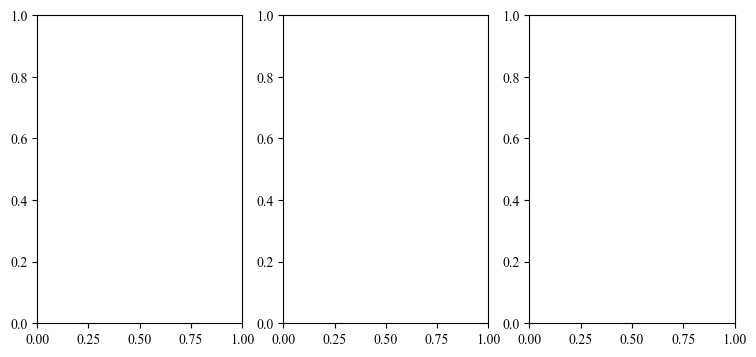

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import itertools
import matplotlib.ticker as ticker

# your existing lists
acquisition_functions = [
    'ThompsonSampling',
    'Stable_Gittins_Lambda_1',
    'Stable_Gittins_Lambda_01',
    'Stable_Gittins_Lambda_001',
    'LogEIWithCost', 
    'UpperConfidenceBound', 
]
acq_col_idxs = {
    'Stable_Gittins_Lambda_1':0,
    'Stable_Gittins_Lambda_01':0,
    'Stable_Gittins_Lambda_001':0,
    'LogEIWithCost':1, 
    'UpperConfidenceBound':2, 
    'ThompsonSampling':3
}

name_dict = {
    'Stable_Gittins_Lambda_1': "PBGI(0.1)",
    'Stable_Gittins_Lambda_01': "PBGI(0.01)",
    'Stable_Gittins_Lambda_001':"PBGI(0.001)",
    'LogEIWithCost':"LogEIC", 
    'UpperConfidenceBound': "LCB", 
    'ThompsonSampling': "TS", 
    'PRB_0_1': "PRB",
    'LogEIC': "PBGI/LogEIC",
    'LogEIC-med':"LogEIC-med", 
    'UCB-LCB': "UCB-LCB",
    'Convergence': "Convergence",
    'GSS': "GSS",
    'SRGap-med':"SRGap-med",
    'uniform': "Uniform Cost",
    'linear': "Linear Cost",
    'periodic': "Periodic Cost" 
}
lmbda_to_str = {
    0.1:'1',
    0.01:'01',
    0.001: '001'
}

color_dict = {
    'LogEIC':                  'tab:orange',
    'LogEIWithCost':           'tab:blue',
    'LogEIC-med':              'tab:blue',
    'Stable_Gittins_Lambda_1': 'tab:orange',
    'Stable_Gittins_Lambda_01':'tab:orange',
    'Stable_Gittins_Lambda_001':'tab:orange',
    'UpperConfidenceBound':    'tab:purple',
    'UCB-LCB':                 'tab:purple',
    'SRGap-med':               'tab:pink',
    'ThompsonSampling':        'tab:brown',
    'PRB_0_1':                 'tab:brown',
    'GSS':                     'tab:olive',
    'Convergence':             'tab:gray',
    'Hindsight':               'tab:red'
}
marker_dict = {
    0.1: 'o',
    0.01: '^',
    0.001: 's'
}

lengthscales = [0.1]
# lengthscales = [0.05, 0.1, 0.2, 0.5]
# cost_type = ['uniform']
cost_type = ['uniform', 'linear', 'periodic']
# lambda_per_acq = [0.1, 0.01, 0.001]
lambda_per_acq = [0.1, 0.01, 0.001]
lengthscales = [0.1]
# --- stopping‐rule parameters ---
delta = 0.05                        # for PRB: stop when P(success) > 1 – delta
ucb_lcb_threshold = 0.01           # for UCB–LCB: stop when (UCB – LCB) < threshold
convergence_window = 5
gss_window = 5 
gss_frac = 0.01             

# 'SRGap-med'
stopping_rules = [
    'LogEIC',
    'UCB-LCB',
    'PRB_0_1',
    'Convergence',
    'GSS',
    'SRGap-med',
    'LogEIC-med',
]

iteration_cutoff = {}
iteration_cutoff[0.1]= 20
iteration_cutoff[0.01]= 50
iteration_cutoff[0.001]= 100

l = 0.1


# build list of column settings
col_settings = list(itertools.product(cost_type))
n_rows = len(col_settings)
n_cols = len(acquisition_functions)-2

for lmbda in lambda_per_acq:

    # Hack by Ziv: transpose axes

    fig, axes = plt.subplots(
        1, n_rows, # n_rows, n_cols,
        figsize=(3 * n_rows, 4 * 1), # (4 * n_cols, 3 * n_rows),  # adjust per‐subplot size
        sharex=False, sharey=False
    )
    axes = axes.T
    # ensure axes is always shape (n_rows, n_cols)
    axes = np.array(axes)
    if axes.ndim == 1:
        # if only one row, shape (n_cols,) → (1, n_cols)
        if n_rows == 1:
            axes = axes[np.newaxis, :]
        # if only one col, shape (n_rows,) → (n_rows, 1)
        else:
            axes = axes[:, np.newaxis]

    for row_idx, cost in enumerate(cost_type):
        max_y = 0
        min_y = 100
        x_labels = [""] * n_cols
        for a in acquisition_functions: # col_idx, a in enumerate(acquisition_functions):
            # print(a.split("_")[-1])
            if a.split("_")[0] == "Stable" and a.split("_")[-1] != lmbda_to_str[lmbda]:
                continue

            ax = axes[row_idx, 0] # acq_col_idxs[a]]
            col_idx = acq_col_idxs[a]
            x_labels[col_idx] = name_dict[a]

            metric_keys = [
                "cumulative cost",
                "best observed",
                "regret", 
                "StablePBGI(0.1) acq",
                "StablePBGI(0.01) acq",
                "StablePBGI(0.001) acq",
                "LogEIC acq", 
                "UCB-LCB acq", 
                "Regret-Gap acq", 
                "PRB_0.1"
            ]
            
            regret = np.array(metrics_per_acq[(a, l, cost)]['regret'])[:, :iteration_cutoff[lmbda]]
            cumulative_cost = np.array(metrics_per_acq[(a, l, cost)]["cumulative cost"])[:, :iteration_cutoff[lmbda]]
            LogEIC_acq = np.array(metrics_per_acq[(a, l, cost)]["LogEIC acq"])[:, :iteration_cutoff[lmbda]]
            UCB_LCB_acq = np.array(metrics_per_acq[(a, l, cost)]["UCB-LCB acq"])[:, :iteration_cutoff[lmbda]]
            PRB_0_1_acq = np.array(metrics_per_acq[(a, l, cost)]["PRB_0.1"])[:, :iteration_cutoff[lmbda]]
            RegretGap_acq = np.array(metrics_per_acq[(a, l, cost)]["Regret-Gap acq"])[:, :iteration_cutoff[lmbda]] 
            # current_best = np.array(current_best_per_acq[(a, l)])[:, :iteration_cutoff]
            best_observed = np.array(metrics_per_acq[(a, l, cost)]["best observed"])[:, :iteration_cutoff[lmbda]]

            # Compute cost-adjusted regret curve
            cost_adjusted_regret = regret + lmbda * cumulative_cost

            # === 1. Compute stopping point, which is the first time acq < best observed 
            stopping_times = {}
            stopping_cost_adjusted_regrets = {}
            for stopping_rule in stopping_rules: 
                stopping_cost_adjusted_regrets[stopping_rule] = []
                stopping_times[stopping_rule] = []
            
            hindsight_best_times = []
            hindsight_best_regrets = []

            n_seeds = regret.shape[0]
            # valid_seed_indices = []

            for seed_idx in range(n_seeds):
                # acq_seed = acq[seed_idx]
                # print (acq_seed)
                best_obs_seed = best_observed[seed_idx]
                stopping_indices = return_stopping_indices(
                    best_obs_seed=best_obs_seed,
                    LogEIC_seed=LogEIC_acq[seed_idx],
                    UCB_LCB_seed=UCB_LCB_acq[seed_idx],
                    PRB_seed=PRB_0_1_acq[seed_idx],
                    RegretGap_seed=RegretGap_acq[seed_idx],
                    lmbda=lmbda,
                    max_iter=iteration_cutoff[lmbda],
                    ucb_lcb_threshold=ucb_lcb_threshold,
                    delta=delta,
                    convergence_window=convergence_window,
                    gss_window=gss_window,
                    gss_frac=gss_frac
                )

                # Only include if stopping condition met
                for stopping_rule in stopping_rules:
                    i_stop = stopping_indices[stopping_rule]
                    stopping_times[stopping_rule].append(stopping_indices[stopping_rule])
                    cost_adj_regret_at_stop = cost_adjusted_regret[seed_idx, i_stop]
                    stopping_cost_adjusted_regrets[stopping_rule].append(cost_adj_regret_at_stop)

                i_best = np.argmin(cost_adjusted_regret[seed_idx])
                hindsight_best_times.append(i_best)
                hindsight_best_regrets.append(cost_adjusted_regret[seed_idx, i_best])
        
            # Convert to arrays

            for stopping_rule in stopping_rules:
                stopping_times[stopping_rule] = np.array(stopping_times[stopping_rule])
                stopping_cost_adjusted_regrets[stopping_rule] = np.array(stopping_cost_adjusted_regrets[stopping_rule])
            
            # # Compute cost-adjusted regret curve
            # # cost_adjusted_regret = cost_adjusted_regret[valid_seed_indices]
            # # Mean and standard error over seeds
            # # print(cost_adjusted_regret.shape[0])
            # mean_curve, stderr_curve = mean_and_std(cost_adjusted_regret, cost_adjusted_regret.shape[0])

            # # Plot mean curve and fill error bars
            # x = np.arange(len(mean_curve))
            # ax.plot(mean_curve, label='Fix iteration mean regret', linestyle='--', color=color_dict[a], zorder=1)
            # ax.fill_between(np.arange(len(mean_curve)), 
            #                 mean_curve - stderr_curve,
            #                 mean_curve + stderr_curve, 
            #                 color=color_dict[a],
            #                 alpha=0.2, zorder=1)
            
            
            # plot stopping markers
            #cmap = plt.get_cmap('tab10')
            #color_dict = {rule: cmap(i) for i, rule in enumerate(stopping_rules)}
            # color_dict['hindsight'] = cmap(len(stopping_rules))

            for i, rule in enumerate(stopping_rules):
                mt,ms = mean_and_std(stopping_times[rule], n_seeds) 
                et,es = mean_and_std(stopping_cost_adjusted_regrets[rule], n_seeds)
                max_y = max(max_y, et + es)
                if rule == 'LogEIC':
                    zorder=3
                else:
                    zorder=2
                ax.errorbar(col_idx - 0.25 + 0.5 * ((i + 1) / len(stopping_rules)), # mt,
                            et, # xerr=ms,
                            yerr=es,
                            fmt='s', color=color_dict[rule], capsize=6, label=name_dict[rule], zorder=zorder)
            
            mean_hindsight_time, stderr_hindsight_time = mean_and_std(hindsight_best_times, n_seeds)
            mean_hindsight_regret, stderr_hindsight_regret = mean_and_std(hindsight_best_regrets, n_seeds) 
            
            ax.errorbar(col_idx - 0.25, # mean_hindsight_time,
                        mean_hindsight_regret,
                        # xerr=stderr_hindsight_time,
                        yerr=stderr_hindsight_regret,
                        fmt='x', color=color_dict['Hindsight'], capsize=6, label='Hindsight')

        print(f"limits: {0}, {max_y}")

        # if row_idx == n_rows - 1:
        #     ax.set_xlabel("Acquisition function", fontsize=14)
        ax.set_title(name_dict[cost], fontsize=14)
        
        ax.set_ylim(0, max_y*1.1)
        ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.1f'))
        ax.set_xlim(-0.9, n_cols - 0.1)
        x_labels = [name.split('(')[0] for name in x_labels]
        print(x_labels)
        ax.set_xticks(range(len(x_labels)))
        ax.set_xticklabels(x_labels)
        ax.set_xticks([x + 0.5 for x in range(-1, n_cols)], minor=True)
        # ax.tick_params(axis='x', which='minor', length=0)
        ax.yaxis.grid(True, linestyle='--', alpha=0.4)
        ax.xaxis.grid(True, which='minor', linestyle='--', alpha=0.4)

    # fig.text(0.04, 0.5, f'{kernel} Cost‐adjusted Simple Regret (lambda={lmbda})', va='center', rotation='vertical', fontsize=14)
    
    # one legend for entire figure (optional)
    # handles, labels = axes[0,0].get_legend_handles_labels()
    legend_hls = dict(zip(*reversed(axes[0,0].get_legend_handles_labels())))
    fig.legend(legend_hls.values(), legend_hls.keys(), # handles, labels,
               loc='lower center',
               bbox_to_anchor=(0.5, -0.08),
               ncol=len(stopping_rules),
               fontsize=14)
    # fig.legend(handles, labels, loc='lower right', ncol=2)
    # fig.legend(handles, labels, loc='upper right', ncol=2)
    fig.suptitle(f'Synthetic 1D Iteration vs Cost-Adjusted Regret (λ = {lmbda})', fontsize=16)
    # plt.tight_layout(rect=[0, 0.0, 1, 0.95])
    # plt.xlim(-1, iteration_cutoff[lmbda])
    # plt.title('{kernel} Cost Adjusted Regret(lambda={lmbda})')
    # plt.savefig(f'../plots/{kernel}_1D_{lmbda_to_str[lmbda]}.png', bbox_inches='tight')
    plt.show()